In [ ]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [ ]:
!pip install hf_xet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 77.1 MB/s eta 0:00:00


# Dataset

In [ ]:
from itertools import islice
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
import os


In [ ]:
import sentencepiece as spm
import torch

class SentencePieceTokenizer:
    def __init__(self, model_path, max_length=1024):
        self.sp = spm.SentencePieceProcessor()
        self.sp.load(model_path)
        self.max_length = max_length
        self.bos_id = self.sp.bos_id()
        self.eos_id = self.sp.eos_id()
        self.unk_id = self.sp.unk_id()
        self.pad_id = self.sp.pad_id()

    def __call__(self, texts, truncation=True, padding="max_length", return_tensors="pt"):
        token_ids = []
        for text in texts:
            ids = self.sp.encode(text, out_type=int)
            if truncation:
                ids = ids[:self.max_length]
            if padding == "max_length":
                ids += [self.pad_id] * (self.max_length - len(ids))
            token_ids.append(ids)
        return {"input_ids": torch.tensor(token_ids)}


In [ ]:

from datasets import load_dataset
from itertools import islice
import os
import torch
from torch.utils.data import DataLoader
context_len = 1024
batch_size = 8

# # === Tokenizer ===
# tokenizer = AutoTokenizer.from_pretrained("gpt2")
# tokenizer.pad_token = tokenizer.eos_token
# Initialize tokenizer
tokenizer = SentencePieceTokenizer("/content/drive/MyDrive/c4_spm_8000_final.model", max_length=1024)

# === Load pre-cached deterministic datasets ===
def load_cached_dataset(cache_path):
    if not os.path.exists(cache_path):
        raise FileNotFoundError(f"Cached dataset not found at: {cache_path}")
    print(f"[Dataset] Loading cached dataset from {cache_path}...")
    return torch.load(cache_path, weights_only=False)

train_dataset = load_cached_dataset("/content/drive/MyDrive/cached_train_sp.pt")
val_dataset = load_cached_dataset("/content/drive/MyDrive/cached_val_sp.pt")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


[Dataset] Loading cached dataset from /content/drive/MyDrive/cached_train_sp.pt...
[Dataset] Loading cached dataset from /content/drive/MyDrive/cached_val_sp.pt...


# Shared Pool FFN - Sigma MoE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import Optional, Tuple
from dataclasses import dataclass

@dataclass
class AttentionMask:
    src_length_mask: Optional[torch.Tensor]
    position_mask: Optional[torch.Tensor]


def log_mean(x: torch.Tensor, dim: int = 0):
    return x.logsumexp(dim) - math.log(x.shape[dim])


def entropy_l(l: torch.Tensor) -> torch.Tensor:
    return - (l * l.exp()).sum(-1)


# def entropy_reg(sel: torch.Tensor, dim: int) -> torch.Tensor:
#     sel = F.log_softmax(sel, dim=-1)
#     sel = log_mean(sel, dim)
#     return -entropy_l(sel).mean()

# def entropy_reg(sel: torch.Tensor, dim: int) -> torch.Tensor:
#     sel = F.log_softmax(sel, dim=dim)
#     log_mean = torch.logsumexp(sel, dim=dim) - math.log(sel.shape[dim])
#     return -(log_mean.exp() * log_mean).sum(-1).mean()


def entropy_reg(sel: torch.Tensor, dim: int) -> torch.Tensor:
    probs = F.softmax(sel, dim=dim)
    log_probs = F.log_softmax(sel, dim=dim)
    entropy = -(probs * log_probs).sum(dim=-1)
    return entropy.mean()

class SigmaMoE(nn.Module):
    def __init__(self, dmodel: int, n_experts: int, expert_size: int, k: int,
                 activation=F.relu,
                 v_dim: Optional[int] = None,
                 expert_dropout: float = 0.0):

        super().__init__()
        self.k_dim = dmodel
        self.v_dim = v_dim if v_dim is not None else dmodel
        self.n_experts = n_experts
        self.expert_size = expert_size
        self.k = k
        self.activation = activation
        self.expert_dropout = expert_dropout
        self.sel_hist = []

        # Expert parameters
        self.keys = nn.Parameter(torch.empty(n_experts, self.k_dim, self.expert_size))
        self.values = nn.Parameter(torch.empty(n_experts, self.expert_size, self.v_dim))
        self.expert_sel = nn.Parameter(torch.empty(n_experts, self.k_dim))

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.normal_(self.expert_sel, 0, 1.0 / math.sqrt(self.k_dim))
        torch.nn.init.normal_(self.keys, 0, 1.0 / math.sqrt(self.k_dim))
        torch.nn.init.normal_(self.values, 0, 1.0 / math.sqrt(self.n_experts * self.expert_size))

    def get_reg_loss(self) -> torch.Tensor:
        if not self.sel_hist:
            return torch.tensor(0.0, device=self.expert_sel.device)
        # loss = entropy_reg(torch.stack(self.sel_hist, dim=-2).flatten(-3, -2), -2)
        loss = entropy_reg(torch.stack(self.sel_hist, dim=0).flatten(0, -2), -1)
        self.sel_hist = []
        return loss

    def forward(self, x: torch.Tensor, sel_input: Optional[torch.Tensor] = None) -> torch.Tensor:
        B, T, D = x.shape
        inp = sel_input if sel_input is not None else x  # selection input
        sel = F.linear(inp, self.expert_sel)  # [B, T, n_experts]
        if self.training:
            self.sel_hist.append(sel)

        if self.training and self.expert_dropout > 0:
            mask = torch.rand_like(sel) < self.expert_dropout
            sel = sel.masked_fill(mask, float("-inf"))

        sel_val, sel_idx = sel.topk(self.k, dim=-1)  # Top-k routing
        weights = F.softmax(sel_val, dim=-1)  # Soft weighting of top-k

        expert_out = torch.zeros(B, T, self.v_dim, device=x.device)
        for i in range(self.k):
            indices = sel_idx[..., i]  # [B, T]
            w = weights[..., i]  # [B, T]

            expert_emb = torch.einsum('btd,edh->bteh', x, self.keys)  # [B, T, n_experts, H]
            expert_emb = self.activation(expert_emb)

            out_proj = torch.einsum('bteh,ehd->bted', expert_emb, self.values)  # [B, T, n_experts, D]

            expert_out += torch.sum(
                F.one_hot(indices, self.n_experts).unsqueeze(-1) * out_proj * w.unsqueeze(-1).unsqueeze(-1),
                dim=2
            )  # sum over experts

        return expert_out


In [ ]:
class SigmaMoELayer(nn.Module):
    def __init__(self, d_model, n_heads, shared_ffn: nn.Module, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.ffn = shared_ffn  # now shared
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        x = self.ln1(x)
        x, _ = self.attn(x, x, x, need_weights=False)
        x = residual + self.drop(x)

        residual = x
        x = self.ln2(x)
        x = self.ffn(x)
        return residual + x


class SigmaMoELM(nn.Module):
    def __init__(self, n_tokens: int, d_model: int, n_layers: int, n_heads: int,
                 ff_n_experts: int, ff_expert_size: int, ff_k: int = 8, dropout: float = 0.1,
                 ff_expert_dropout: float = 0.0, entropy_reg: float = 0.01):
        super().__init__()
        self.embedding = nn.Embedding(n_tokens, d_model)

        # Shared FFN
        self.shared_ffn = SigmaMoE(d_model, ff_n_experts, ff_expert_size, k=ff_k, expert_dropout=ff_expert_dropout)

        self.layers = nn.ModuleList([
            SigmaMoELayer(d_model, n_heads, self.shared_ffn, dropout)
            for _ in range(n_layers)
        ])
        self.out_norm = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, n_tokens)
        self.entropy_reg = entropy_reg

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_normal_(self.embedding.weight)
        for layer in self.modules():
            if isinstance(layer, nn.LayerNorm):
                nn.init.ones_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        x = self.out_norm(x)
        logits = self.lm_head(x)

        # Single shared MoE used, collect its reg loss
        reg_loss = self.entropy_reg * self.shared_ffn.get_reg_loss()

        return logits, reg_loss


# Grouped Pool

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import Optional, Tuple
from dataclasses import dataclass

@dataclass
class AttentionMask:
    src_length_mask: Optional[torch.Tensor]
    position_mask: Optional[torch.Tensor]


def log_mean(x: torch.Tensor, dim: int = 0):
    return x.logsumexp(dim) - math.log(x.shape[dim])


def entropy_l(l: torch.Tensor) -> torch.Tensor:
    return - (l * l.exp()).sum(-1)


# def entropy_reg(sel: torch.Tensor, dim: int) -> torch.Tensor:
#     sel = F.log_softmax(sel, dim=-1)
#     sel = log_mean(sel, dim)
#     return -entropy_l(sel).mean()

# def entropy_reg(sel: torch.Tensor, dim: int) -> torch.Tensor:
#     sel = F.log_softmax(sel, dim=dim)
#     log_mean = torch.logsumexp(sel, dim=dim) - math.log(sel.shape[dim])
#     return -(log_mean.exp() * log_mean).sum(-1).mean()


def entropy_reg(sel: torch.Tensor, dim: int) -> torch.Tensor:
    probs = F.softmax(sel, dim=dim)
    log_probs = F.log_softmax(sel, dim=dim)
    entropy = -(probs * log_probs).sum(dim=-1)
    return entropy.mean()

class SigmaMoE(nn.Module):
    def __init__(self, dmodel: int, n_experts: int, expert_size: int, k: int,
                 activation=F.relu,
                 v_dim: Optional[int] = None,
                 expert_dropout: float = 0.0):

        super().__init__()
        self.k_dim = dmodel
        self.v_dim = v_dim if v_dim is not None else dmodel
        self.n_experts = n_experts
        self.expert_size = expert_size
        self.k = k
        self.activation = activation
        self.expert_dropout = expert_dropout
        self.sel_hist = []

        # Expert parameters
        self.keys = nn.Parameter(torch.empty(n_experts, self.k_dim, self.expert_size))
        self.values = nn.Parameter(torch.empty(n_experts, self.expert_size, self.v_dim))
        self.expert_sel = nn.Parameter(torch.empty(n_experts, self.k_dim))

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.normal_(self.expert_sel, 0, 1.0 / math.sqrt(self.k_dim))
        torch.nn.init.normal_(self.keys, 0, 1.0 / math.sqrt(self.k_dim))
        torch.nn.init.normal_(self.values, 0, 1.0 / math.sqrt(self.n_experts * self.expert_size))

    def get_reg_loss(self) -> torch.Tensor:
        if not self.sel_hist:
            return torch.tensor(0.0, device=self.expert_sel.device)
        # loss = entropy_reg(torch.stack(self.sel_hist, dim=-2).flatten(-3, -2), -2)
        loss = entropy_reg(torch.stack(self.sel_hist, dim=0).flatten(0, -2), -1)
        self.sel_hist = []
        return loss

    def forward(self, x: torch.Tensor, sel_input: Optional[torch.Tensor] = None) -> torch.Tensor:
        B, T, D = x.shape
        inp = sel_input if sel_input is not None else x  # selection input
        sel = F.linear(inp, self.expert_sel)  # [B, T, n_experts]
        if self.training:
            self.sel_hist.append(sel)

        if self.training and self.expert_dropout > 0:
            mask = torch.rand_like(sel) < self.expert_dropout
            sel = sel.masked_fill(mask, float("-inf"))

        sel_val, sel_idx = sel.topk(self.k, dim=-1)  # Top-k routing
        weights = F.softmax(sel_val, dim=-1)  # Soft weighting of top-k

        expert_out = torch.zeros(B, T, self.v_dim, device=x.device)
        for i in range(self.k):
            indices = sel_idx[..., i]  # [B, T]
            w = weights[..., i]  # [B, T]

            expert_emb = torch.einsum('btd,edh->bteh', x, self.keys)  # [B, T, n_experts, H]
            expert_emb = self.activation(expert_emb)

            out_proj = torch.einsum('bteh,ehd->bted', expert_emb, self.values)  # [B, T, n_experts, D]

            expert_out += torch.sum(
                F.one_hot(indices, self.n_experts).unsqueeze(-1) * out_proj * w.unsqueeze(-1).unsqueeze(-1),
                dim=2
            )  # sum over experts

        return expert_out


In [ ]:
class SigmaMoELayer(nn.Module):
    def __init__(self, d_model, n_heads, ffn: nn.Module, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.ffn = ffn  # now shared
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        x = self.ln1(x)
        x, _ = self.attn(x, x, x, need_weights=False)
        x = residual + self.drop(x)

        residual = x
        x = self.ln2(x)
        x = self.ffn(x)
        return residual + x


class SigmaMoELM(nn.Module):
    def __init__(self, n_tokens: int, d_model: int, n_layers: int, n_heads: int,
                 ff_n_experts: int, ff_expert_size: int, ff_k: int = 8, dropout: float = 0.1,
                 ff_expert_dropout: float = 0.0, entropy_reg: float = 0.01):
        super().__init__()
        self.embedding = nn.Embedding(n_tokens, d_model)

        # Shared FFN
        n_groups = 2
        # self.shared_ffn = SigmaMoE(d_model, ff_n_experts, ff_expert_size, k=ff_k, expert_dropout=ff_expert_dropout)
        assert n_layers % n_groups == 0, "n_layers must be divisible by n_groups"
        layers_per_group = n_layers // n_groups

        # Create grouped FFNs
        self.grouped_ffns = nn.ModuleList([
            SigmaMoE(d_model, ff_n_experts, ff_expert_size, k=ff_k, expert_dropout=ff_expert_dropout)
            for _ in range(n_groups)
        ])

        # Assign layers to groups
        self.layers = nn.ModuleList()
        for i in range(n_layers):
            group_idx = i // layers_per_group
            ffn = self.grouped_ffns[group_idx]
            self.layers.append(SigmaMoELayer(d_model, n_heads, ffn, dropout))


        # self.layers = nn.ModuleList([
        #     SigmaMoELayer(d_model, n_heads, self.shared_ffn, dropout)
        #     for _ in range(n_layers)
        # ])
        self.out_norm = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, n_tokens)
        self.entropy_reg = entropy_reg

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_normal_(self.embedding.weight)
        for layer in self.modules():
            if isinstance(layer, nn.LayerNorm):
                nn.init.ones_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        x = self.out_norm(x)
        logits = self.lm_head(x)

        # Single shared MoE used, collect its reg loss
        # reg_loss = self.entropy_reg * self.ffn.get_reg_loss()
        reg_loss = torch.zeros(1, device=x.device)

        for moe in self.grouped_ffns:
            reg_loss += self.entropy_reg * moe.get_reg_loss()


        return logits, reg_loss


# Shared Pool

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import Optional, Tuple
from dataclasses import dataclass

@dataclass
class AttentionMask:
    src_length_mask: Optional[torch.Tensor]
    position_mask: Optional[torch.Tensor]


def log_mean(x: torch.Tensor, dim: int = 0):
    return x.logsumexp(dim) - math.log(x.shape[dim])


def entropy_l(l: torch.Tensor) -> torch.Tensor:
    return - (l * l.exp()).sum(-1)


def entropy_reg(sel: torch.Tensor, dim: int) -> torch.Tensor:
    sel = F.log_softmax(sel, dim=-1)
    sel = log_mean(sel, dim)
    return -entropy_l(sel).mean()

# def entropy_reg(sel: torch.Tensor, dim: int) -> torch.Tensor:
#     sel = F.log_softmax(sel, dim=dim)
#     log_mean = torch.logsumexp(sel, dim=dim) - math.log(sel.shape[dim])
#     return -(log_mean.exp() * log_mean).sum(-1).mean()



class SigmaMoE(nn.Module):
    def __init__(self, dmodel: int, n_experts: int, expert_size: int, k: int,
                 activation=F.relu,
                 v_dim: Optional[int] = None,
                 expert_dropout: float = 0.0):

        super().__init__()
        self.k_dim = dmodel
        self.v_dim = v_dim if v_dim is not None else dmodel
        self.n_experts = n_experts
        self.expert_size = expert_size
        self.k = k
        self.activation = activation
        self.expert_dropout = expert_dropout
        self.sel_hist = []

        # Expert parameters
        self.keys = nn.Parameter(torch.empty(n_experts, self.k_dim, self.expert_size))
        self.values = nn.Parameter(torch.empty(n_experts, self.expert_size, self.v_dim))
        self.expert_sel = nn.Parameter(torch.empty(n_experts, self.k_dim))

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.normal_(self.expert_sel, 0, 1.0 / math.sqrt(self.k_dim))
        torch.nn.init.normal_(self.keys, 0, 1.0 / math.sqrt(self.k_dim))
        torch.nn.init.normal_(self.values, 0, 1.0 / math.sqrt(self.n_experts * self.expert_size))

    def get_reg_loss(self) -> torch.Tensor:
        if not self.sel_hist:
            return torch.tensor(0.0, device=self.expert_sel.device)
        loss = entropy_reg(torch.stack(self.sel_hist, dim=-2).flatten(-3, -2), -2)
        # loss = entropy_reg(torch.stack(self.sel_hist, dim=0).flatten(0, -2), -1)
        self.sel_hist = []
        return loss

    def forward(self, x: torch.Tensor, sel_input: Optional[torch.Tensor] = None) -> torch.Tensor:
        B, T, D = x.shape
        inp = sel_input if sel_input is not None else x  # selection input
        sel = F.linear(inp, self.expert_sel)  # [B, T, n_experts]
        if self.training:
            self.sel_hist.append(sel)

        if self.training and self.expert_dropout > 0:
            mask = torch.rand_like(sel) < self.expert_dropout
            sel = sel.masked_fill(mask, float("-inf"))

        sel_val, sel_idx = sel.topk(self.k, dim=-1)  # Top-k routing
        weights = F.softmax(sel_val, dim=-1)  # Soft weighting of top-k

        expert_out = torch.zeros(B, T, self.v_dim, device=x.device)
        for i in range(self.k):
            indices = sel_idx[..., i]  # [B, T]
            w = weights[..., i]  # [B, T]

            expert_emb = torch.einsum('btd,edh->bteh', x, self.keys)  # [B, T, n_experts, H]
            expert_emb = self.activation(expert_emb)

            out_proj = torch.einsum('bteh,ehd->bted', expert_emb, self.values)  # [B, T, n_experts, D]

            expert_out += torch.sum(
                F.one_hot(indices, self.n_experts).unsqueeze(-1) * out_proj * w.unsqueeze(-1).unsqueeze(-1),
                dim=2
            )  # sum over experts

        return expert_out


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple

class SigmaMoELayer(nn.Module):
    def __init__(self, d_model, n_heads, ff_n_experts, ff_expert_size, ff_k=8, ff_expert_dropout=0.0, dropout=0.1, shared_ffn=None):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        # self.ffn = SigmaMoE(d_model, ff_n_experts, ff_expert_size, k=ff_k, expert_dropout=ff_expert_dropout)
        self.ffn = shared_ffn
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        x = self.ln1(x)
        x, _ = self.attn(x, x, x, need_weights=False)
        x = residual + self.drop(x)

        residual = x
        x = self.ln2(x)
        x = self.ffn(x)
        return residual + x

class SigmaMoELM(nn.Module):
    def __init__(self, n_tokens: int, d_model: int, n_layers: int, n_heads: int,
                 ff_n_experts: int, ff_expert_size: int, ff_k: int = 8, dropout: float = 0.1,
                 ff_expert_dropout: float = 0.0, entropy_reg: float = 0.01):
        super().__init__()
        self.embedding = nn.Embedding(n_tokens, d_model)
        self.shared_ffn = SigmaMoE(d_model, ff_n_experts, ff_expert_size, k=ff_k, expert_dropout=ff_expert_dropout)
        self.layers = nn.ModuleList([
            SigmaMoELayer(d_model, n_heads, ff_n_experts, ff_expert_size, ff_k, ff_expert_dropout, dropout, shared_ffn=self.shared_ffn)
            for _ in range(n_layers)
        ])
        self.out_norm = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, n_tokens)
        self.entropy_reg = entropy_reg

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_normal_(self.embedding.weight)
        for layer in self.modules():
            if isinstance(layer, nn.LayerNorm):
                nn.init.ones_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        x = self.out_norm(x)
        logits = self.lm_head(x)

        # # collect entropy loss
        # reg_loss = torch.zeros(1, device=x.device)
        # for layer in self.modules():
        #     if isinstance(layer, SigmaMoE):
        #         reg_loss += self.entropy_reg * layer.get_reg_loss()
        reg_loss = self.entropy_reg * self.shared_ffn.get_reg_loss()
        return logits, reg_loss


# Depth Aware

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import Optional, Tuple
from dataclasses import dataclass

@dataclass
class AttentionMask:
    src_length_mask: Optional[torch.Tensor]
    position_mask: Optional[torch.Tensor]


def log_mean(x: torch.Tensor, dim: int = 0):
    return x.logsumexp(dim) - math.log(x.shape[dim])


def entropy_l(l: torch.Tensor) -> torch.Tensor:
    return - (l * l.exp()).sum(-1)


def entropy_reg(sel: torch.Tensor, dim: int) -> torch.Tensor:
    sel = F.log_softmax(sel, dim=-1)
    sel = log_mean(sel, dim)
    return -entropy_l(sel).mean()

# def entropy_reg(sel: torch.Tensor, dim: int) -> torch.Tensor:
#     sel = F.log_softmax(sel, dim=dim)
#     log_mean = torch.logsumexp(sel, dim=dim) - math.log(sel.shape[dim])
#     return -(log_mean.exp() * log_mean).sum(-1).mean()



class SigmaMoE(nn.Module):
    def __init__(self, dmodel: int, n_experts: int, expert_size: int, k: int,
                 activation=F.relu,
                 v_dim: Optional[int] = None,
                 expert_dropout: float = 0.0, layer_embed_dim=64):

        super().__init__()
        self.k_dim = dmodel
        self.v_dim = v_dim if v_dim is not None else dmodel
        self.n_experts = n_experts
        self.expert_size = expert_size
        self.k = k
        self.activation = activation
        self.expert_dropout = expert_dropout
        self.sel_hist = []

        # Expert parameters
        self.keys = nn.Parameter(torch.empty(n_experts, self.k_dim, self.expert_size))
        self.values = nn.Parameter(torch.empty(n_experts, self.expert_size, self.v_dim))
        self.expert_sel = nn.Parameter(torch.empty(n_experts, self.k_dim))  # Layer embedding size = 64
        # self.layer_proj = nn.Linear(layer_embed_dim, dmodel)  # projection to match d_model
        self.ln = nn.LayerNorm(dmodel)  # LayerNorm after addition

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.normal_(self.expert_sel, 0, 1.0 / math.sqrt(self.k_dim))
        torch.nn.init.normal_(self.keys, 0, 1.0 / math.sqrt(self.k_dim))
        torch.nn.init.normal_(self.values, 0, 1.0 / math.sqrt(self.n_experts * self.expert_size))

    def get_reg_loss(self) -> torch.Tensor:
        if not self.sel_hist:
            return torch.tensor(0.0, device=self.expert_sel.device)
        loss = entropy_reg(torch.stack(self.sel_hist, dim=-2).flatten(-3, -2), -2)
        # loss = entropy_reg(torch.stack(self.sel_hist, dim=0).flatten(0, -2), -1)
        self.sel_hist = []
        return loss

    def forward(self, x: torch.Tensor, sel_input: Optional[Tuple[torch.Tensor, torch.Tensor]] = None) -> torch.Tensor:
        B, T, D = x.shape
        if sel_input is not None:
            sel_x, layer_embed = sel_input
            # projected = self.layer_proj(layer_embed)  # [1, 1, d_model]
            # inp = sel_x + layer_embed  # broadcast add: [B, T, d_model]
            inp = sel_x + layer_embed
            # expanded_embed = layer_embed.expand(B, T, -1)
            # inp = torch.cat([sel_x, expanded_embed], dim=-1)
        else:
            inp = x

        sel = F.linear(inp, self.expert_sel)  # [B, T, n_experts]

    # def forward(self, x: torch.Tensor, sel_input: Optional[torch.Tensor] = None) -> torch.Tensor:
        # B, T, D = x.shape
        # inp = sel_input if sel_input is not None else x  # selection input
        # sel = F.linear(inp, self.expert_sel)  # [B, T, n_experts]
        if self.training:
            self.sel_hist.append(sel)

        if self.training and self.expert_dropout > 0:
            mask = torch.rand_like(sel) < self.expert_dropout
            sel = sel.masked_fill(mask, float("-inf"))

        sel_val, sel_idx = sel.topk(self.k, dim=-1)  # Top-k routing
        weights = F.softmax(sel_val, dim=-1)  # Soft weighting of top-k

        expert_out = torch.zeros(B, T, self.v_dim, device=x.device)
        for i in range(self.k):
            indices = sel_idx[..., i]  # [B, T]
            w = weights[..., i]  # [B, T]

            expert_emb = torch.einsum('btd,edh->bteh', x, self.keys)  # [B, T, n_experts, H]
            expert_emb = self.activation(expert_emb)

            out_proj = torch.einsum('bteh,ehd->bted', expert_emb, self.values)  # [B, T, n_experts, D]

            expert_out += torch.sum(
                F.one_hot(indices, self.n_experts).unsqueeze(-1) * out_proj * w.unsqueeze(-1).unsqueeze(-1),
                dim=2
            )  # sum over experts

        return expert_out


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple

class SigmaMoELayer(nn.Module):
    def __init__(self, d_model, n_heads, ff_n_experts, ff_expert_size, ff_k=8, ff_expert_dropout=0.0, dropout=0.1, layer_embed_dim=64, shared_ffn=None):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        # self.ffn = SigmaMoE(d_model, ff_n_experts, ff_expert_size, k=ff_k, expert_dropout=ff_expert_dropout, layer_embed_dim=layer_embed_dim)
        self.ffn = shared_ffn
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)
        self.layer_embed = nn.Parameter(torch.empty(1, 1, d_model))
        torch.nn.init.normal_(self.layer_embed, 0, 1.0 / math.sqrt(d_model))
        # self.gamma = nn.Parameter(torch.ones(1, 1, d_model))
        # self.beta = nn.Parameter(torch.zeros(1, 1, d_model))
        # torch.nn.init.normal_(self.gamma, 0, 1.0 / math.sqrt(d_model))
        # torch.nn.init.normal_(self.beta, 0, 1.0 / math.sqrt(d_model))


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        x = self.ln1(x)
        x, _ = self.attn(x, x, x, need_weights=False)
        x = residual + self.drop(x)

        residual = x
        x = self.ln2(x)
        # x = self.ffn(x)
        x = self.ffn(x, (x, self.layer_embed))

        return residual + x

class SigmaMoELM(nn.Module):
    def __init__(self, n_tokens: int, d_model: int, n_layers: int, n_heads: int,
                 ff_n_experts: int, ff_expert_size: int, ff_k: int = 8, dropout: float = 0.1,
                 ff_expert_dropout: float = 0.0, entropy_reg: float = 0.01, layer_embed_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(n_tokens, d_model)
        self.shared_ffn = SigmaMoE(d_model, ff_n_experts, ff_expert_size, k=ff_k, expert_dropout=ff_expert_dropout)
        self.layers = nn.ModuleList([
            SigmaMoELayer(d_model, n_heads, ff_n_experts, ff_expert_size, ff_k, ff_expert_dropout, dropout, layer_embed_dim, shared_ffn=self.shared_ffn)
            for _ in range(n_layers)
        ])
        self.out_norm = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, n_tokens)
        self.entropy_reg = entropy_reg

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_normal_(self.embedding.weight)
        for layer in self.modules():
            if isinstance(layer, nn.LayerNorm):
                nn.init.ones_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        x = self.out_norm(x)
        logits = self.lm_head(x)

        # # collect entropy loss
        # reg_loss = torch.zeros(1, device=x.device)
        # for layer in self.modules():
        #     if isinstance(layer, SigmaMoE):
        #         reg_loss += self.entropy_reg * layer.get_reg_loss()
        reg_loss = self.entropy_reg * self.shared_ffn.get_reg_loss()
        return logits, reg_loss


# Init

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset
from torch.optim.lr_scheduler import CosineAnnealingLR
import time



In [ ]:
n_steps = 1000
eval_every = 1
step = 0
start_time = time.time()

In [ ]:
vocab_size = tokenizer.sp.get_piece_size()
d_model = 412
n_layers = 10
ff_expert_size = 82
dropout = 0.0


config = {
    "n_tokens": vocab_size,
    "d_model": d_model,
    "n_layers": n_layers,
    "n_heads": 4,                 # Unused in σ-MoE but kept for consistency
    "ff_n_experts": 13,           # From matched pair
    "ff_expert_size": ff_expert_size,
    "ff_k": 4,                    # Top-k routing
    "dropout": dropout,
    "ff_expert_dropout": 0.0,
    "entropy_reg": 0.01
}


In [ ]:
# --- Model & Optimizer ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SigmaMoELM(**config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2.5e-4, weight_decay=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=n_steps)

## Training

In [ ]:
import os
# prefix = "moe"
# prefix = "shared_pool_depth_aware_20m_1000stps_additive"
# prefix = "shared_pool_depth_aware_20m_10kstps"
# prefix = "shared_pool_non_shared_router_1000stps"
# prefix = "shared_pool_cumulative_layer_embed_1000stps"
# prefix = "shared_pool_no_router_nolayer_1000stps"
# prefix = "shared_pool_shared_router_1000stps"
prefix = "depth_aware_routing_1000stps"

os.makedirs('/content/drive/MyDrive/sigmamoe', exist_ok=True)
os.makedirs('/content/drive/MyDrive/sigmamoe/checkpoints', exist_ok=True)

# === Checkpointing ===
def save_checkpoint(model, optimizer, step, path=f"/content/drive/MyDrive/sigmamoe/checkpoints/{prefix}.pt"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "step": step
    }, path)
    print(f"[Checkpoint] Saved at step {step} → {path}")

def load_checkpoint(model, optimizer, path=f"/content/drive/MyDrive/sigmamoe/checkpoints/{prefix}.pt"):
    if not os.path.exists(path):
        print("[Checkpoint] No checkpoint found.")
        return 0  # start from scratch

    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt['model_state'])
    optimizer.load_state_dict(ckpt["optimizer_state"])
    print(f"[Checkpoint] Loaded from {path} at step {ckpt['step']}")
    return ckpt["step"]

In [ ]:
def evaluate(model, val_loader, vocab_size, device):
    # --- Evaluation Function ---
    model.eval()
    total_loss, total_tokens = 0.0, 0
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            logits, reg_loss = model(x)
            ce_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=tokenizer.pad_id)
            total_loss += (ce_loss.item() + reg_loss.item()) * y.numel()
            total_tokens += y.numel()
    avg_loss = total_loss / total_tokens
    perplexity = torch.exp(torch.tensor(avg_loss))
    print(f"[Eval @ step {step}] Loss: {avg_loss:.4f}, Perplexity: {perplexity:.2f}")
    model.train()


def train_sigmoe_on_c4(model, train_loader, val_loader, device, vocab_size, optimizer, num_steps=1000, eval_every=100):
    model.train()
    # step = load_checkpoint(model, optimizer)
    # --- Training ---'
    loss_history = []
    perplexity = []
    for epoch in range(3):

        step = 0
        for batch in train_loader:
            model.train()
            if step >= n_steps:
                break
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            logits, reg_loss = model(x)
            ce_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=tokenizer.pad_id)
            total_loss = ce_loss + reg_loss

            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)  # gradient clipping
            optimizer.step()
            scheduler.step()
            loss_history.append(total_loss.item())
            perplexity.append(torch.exp(torch.tensor(total_loss.item())).item())

            if step % 10 == 0:
                print(f"[Step {step}] Loss: {ce_loss.item():.4f} + Reg: {reg_loss.item()}")
            if step % eval_every == 0 and step != 0:
                # evaluate(model, val_loader, tokenizer.sp.get_piece_size(), device)
                save_checkpoint(model, optimizer, step)
            step += 1
        if step >= n_steps:
            break

    print(f"Training completed in {(time.time() - start_time)/60:.2f} minutes.")
    return loss_history, perplexity

In [ ]:
loss_history, preplexity = train_sigmoe_on_c4(model, train_loader, val_loader, device, tokenizer.sp.get_piece_size(), optimizer, num_steps=n_steps)

[Step 0] Loss: 9.1692 + Reg: -0.020741576328873634
[Step 10] Loss: 7.8188 + Reg: -0.02079443261027336
[Step 20] Loss: 7.2200 + Reg: -0.024526342749595642
[Step 30] Loss: 7.1738 + Reg: -0.02517351135611534
[Step 40] Loss: 6.9331 + Reg: -0.025311335921287537
[Step 50] Loss: 7.0128 + Reg: -0.025303788483142853
[Step 60] Loss: 7.0863 + Reg: -0.025217270478606224
[Step 70] Loss: 7.0406 + Reg: -0.02467232197523117
[Step 80] Loss: 6.8307 + Reg: -0.024966275319457054
[Step 90] Loss: 6.8855 + Reg: -0.024251772090792656
[Step 100] Loss: 6.7234 + Reg: -0.02428637444972992
[Checkpoint] Saved at step 100 → /content/drive/MyDrive/sigmamoe/checkpoints/depth_aware_routing_1000stps.pt
[Step 110] Loss: 6.8128 + Reg: -0.024806609377264977
[Step 120] Loss: 6.7459 + Reg: -0.02497999370098114
[Step 130] Loss: 7.0037 + Reg: -0.024703318253159523
[Step 140] Loss: 6.6482 + Reg: -0.02521202526986599
[Step 150] Loss: 6.5145 + Reg: -0.02476673573255539
[Step 160] Loss: 6.6803 + Reg: -0.02517750672996044
[Step 170

In [ ]:
from matplotlib import pyplot as plt

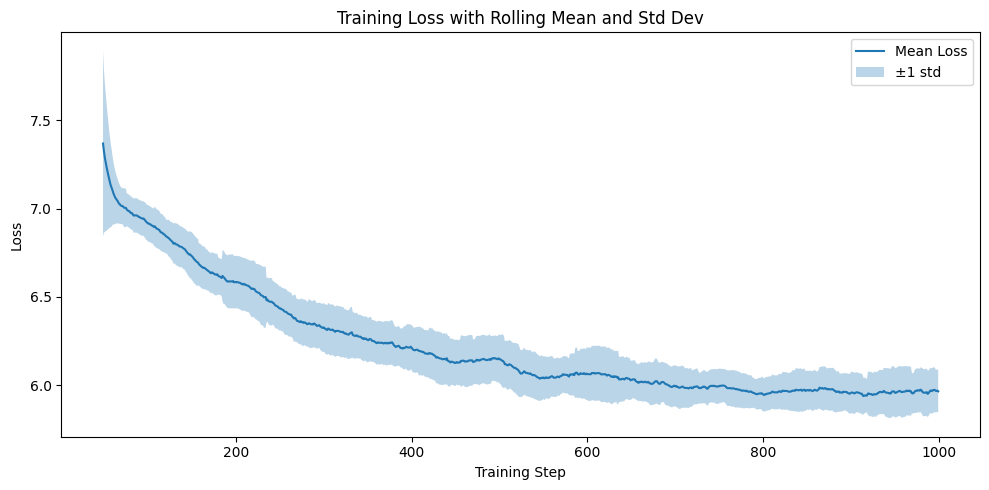

Training completed.


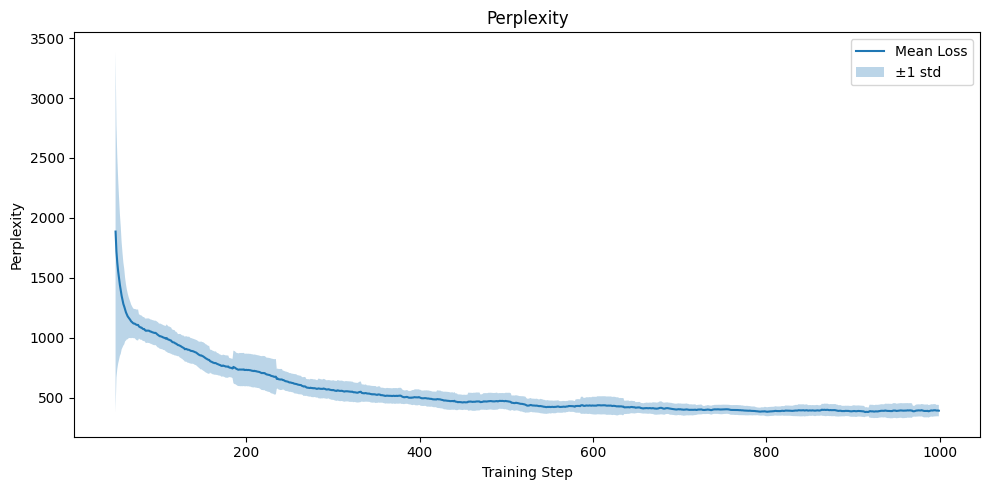

Training completed.


In [ ]:
# Plot loss with rolling mean and std
losses = torch.tensor(loss_history)
window = 50
if len(losses) >= window:
  rolling_mean = losses.unfold(0, window, 1).mean(dim=1)
  rolling_std = losses.unfold(0, window, 1).std(dim=1)
  x_range = range(window - 1, len(losses))

  plt.figure(figsize=(10, 5))
  plt.plot(x_range, rolling_mean, label='Mean Loss')
  plt.fill_between(x_range,
                    rolling_mean - rolling_std,
                    rolling_mean + rolling_std,
                    alpha=0.3, label='±1 std')
  plt.title("Training Loss with Rolling Mean and Std Dev")
  plt.xlabel("Training Step")
  plt.ylabel("Loss")
  plt.legend()
  plt.tight_layout()
  plt.show()

print("Training completed.")


# Plot loss with rolling mean and std
losses = torch.tensor(preplexity)
window = 50
if len(losses) >= window:
  rolling_mean = losses.unfold(0, window, 1).mean(dim=1)
  rolling_std = losses.unfold(0, window, 1).std(dim=1)
  x_range = range(window - 1, len(losses))

  plt.figure(figsize=(10, 5))
  plt.plot(x_range, rolling_mean, label='Mean Loss')
  plt.fill_between(x_range,
                    rolling_mean - rolling_std,
                    rolling_mean + rolling_std,
                    alpha=0.3, label='±1 std')
  plt.title("Perplexity")
  plt.xlabel("Training Step")
  plt.ylabel("Perplexity")
  plt.legend()
  plt.tight_layout()
  plt.show()

print("Training completed.")

In [ ]:
import os
import csv

# Save raw loss values
def save_losses_to_file(losses, filename=f"/content/drive/MyDrive/{prefix}training_loss_log.csv"):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["step", "loss"])
        for i, loss in enumerate(zip(losses, preplexity)):
            writer.writerow([i, loss[0], loss[1]])


In [ ]:
save_losses_to_file(loss_history)


In [ ]:
# Depth Aware Layer Routing
train_sigmoe_on_c4(model, train_loader, val_loader, device, tokenizer.sp.get_piece_size(), optimizer, num_steps=n_steps)

[Step 0] Loss: 9.1404 + Reg: -0.023962106555700302
[Step 10] Loss: 7.7721 + Reg: -0.023438259959220886
[Step 20] Loss: 7.2684 + Reg: -0.02507646195590496
[Step 30] Loss: 7.0184 + Reg: -0.02543991431593895
[Step 40] Loss: 7.1136 + Reg: -0.025496041402220726
[Step 50] Loss: 6.9222 + Reg: -0.025280801579356194
[Step 60] Loss: 6.8480 + Reg: -0.025247864425182343
[Step 70] Loss: 6.7968 + Reg: -0.02526603639125824
[Step 80] Loss: 6.8517 + Reg: -0.024966182187199593
[Step 90] Loss: 6.9265 + Reg: -0.02483934536576271
[Step 100] Loss: 6.7291 + Reg: -0.024980420246720314
[Checkpoint] Saved at step 100 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 110] Loss: 6.9086 + Reg: -0.025128833949565887
[Step 120] Loss: 6.6876 + Reg: -0.024971572682261467
[Step 130] Loss: 6.7602 + Reg: -0.024898052215576172
[Step 140] Loss: 6.5797 + Reg: -0.025076068937778473
[Step 150] Loss: 6.6413 + Reg: -0.02500619739294052
[Step 160] Loss: 6.5261 + Reg: -0.025034412741661072

In [ ]:
evaluate(model, val_loader, tokenizer.sp.get_piece_size(), device)

[Eval @ step 0] Loss: 4.9915, Perplexity: 147.16


In [ ]:
load_checkpoint(model, optimizer)

[Checkpoint] Loaded from /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_non_shared_router_1000stps.pt at step 900


900

# [Eval @ step 0] Loss: 4.9915, Perplexity: 147.16



In [ ]:
evaluate(model, val_loader, tokenizer.sp.get_piece_size(), device)

[Eval @ step 0] Loss: 5.9714, Perplexity: 392.05


In [ ]:
# Additive layer norm with projection -> [Eval @ step 0] Loss: 5.9707, Perplexity: 391.77
# Additive layer norm wihtout projection -> [Eval @ step 0] Loss: 5.9976, Perplexity: 402.44
# Additive no layer norm no projection -> [Eval @ step 0] Loss: 5.9668, Perplexity: 390.26
# FiLM - [Eval @ step 0] Loss: 5.9675, Perplexity: 390.51
# No Shared Router - 394
# Shared Router Cumulative Layer Embeddings - [Eval @ step 0] Loss: 5.9878, Perplexity: 398.56
# Independent router - shared pool - [Eval @ step 0] Loss: 5.9731, Perplexity: 392.71
# Shared router - shared pool - [Eval @ step 0] Loss: 5.9859, Perplexity: 397.78

In [ ]:
import torch
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_shared_layer_embeddings(model):
    # Stack all layer embeddings: shape → [n_layers, d_model]
    layer_embeddings = torch.cat(
        [layer.layer_embed.detach().cpu() for layer in model.layers], dim=0
    ).squeeze(1)

    # Normalize and compute cosine similarity
    normalized = F.normalize(layer_embeddings, dim=-1)
    sim_matrix = torch.matmul(normalized, normalized.T)
    sim_matrix = sim_matrix - torch.eye(sim_matrix.size(0))
    # Plot the heatmap
    plt.figure(figsize=(7, 6))
    sns.heatmap(sim_matrix.numpy(), annot=True, fmt=".2f", cmap="YlGnBu",
                xticklabels=[f"L{i}" for i in range(sim_matrix.size(0))],
                yticklabels=[f"L{i}" for i in range(sim_matrix.size(0))])
    plt.title("Cosine Similarity of Per-Layer Embeddings")
    plt.xlabel("Layer")
    plt.ylabel("Layer")
    plt.tight_layout()
    plt.show()

    return sim_matrix


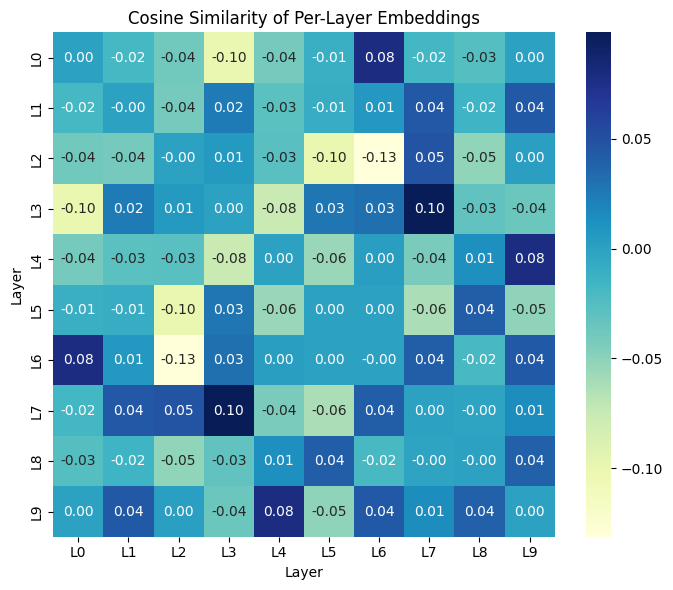

tensor([[ 0.0000e+00, -1.8738e-02, -3.8631e-02, -1.0048e-01, -4.0362e-02,
         -1.0224e-02,  7.8650e-02, -1.7569e-02, -2.6126e-02,  2.1968e-04],
        [-1.8738e-02, -5.9605e-08, -3.9984e-02,  2.4634e-02, -2.8867e-02,
         -8.7459e-03,  6.1968e-03,  4.4689e-02, -1.5199e-02,  4.4381e-02],
        [-3.8631e-02, -3.9984e-02, -1.7881e-07,  5.6382e-03, -2.7793e-02,
         -9.9788e-02, -1.3131e-01,  4.7809e-02, -5.2136e-02,  1.4606e-03],
        [-1.0048e-01,  2.4634e-02,  5.6382e-03,  0.0000e+00, -7.6080e-02,
          2.7020e-02,  3.1194e-02,  9.8558e-02, -3.1621e-02, -3.5491e-02],
        [-4.0362e-02, -2.8867e-02, -2.7793e-02, -7.6080e-02,  1.1921e-07,
         -5.5610e-02,  2.3221e-03, -4.2877e-02,  1.2545e-02,  7.8681e-02],
        [-1.0224e-02, -8.7459e-03, -9.9788e-02,  2.7020e-02, -5.5610e-02,
          0.0000e+00,  4.2640e-04, -6.2529e-02,  4.0832e-02, -5.0512e-02],
        [ 7.8650e-02,  6.1968e-03, -1.3131e-01,  3.1194e-02,  2.3221e-03,
          4.2640e-04, -5.9605e-0

In [ ]:
analyze_shared_layer_embeddings(model)

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

def l2_distance_heatmap(model):
    # Extract layer embeddings: shape → [n_layers, d_model]
    layer_embeddings = torch.cat(
        [layer.layer_embed.detach().cpu() for layer in model.layers], dim=0
    ).squeeze(1)

    n_layers = layer_embeddings.size(0)
    dist_matrix = torch.zeros(n_layers, n_layers)

    # Compute pairwise L2 distances
    for i in range(n_layers):
        for j in range(n_layers):
            dist = torch.norm(layer_embeddings[i] - layer_embeddings[j], p=2)
            dist_matrix[i, j] = dist

    # Plot the heatmap
    plt.figure(figsize=(7, 6))
    sns.heatmap(dist_matrix.numpy(), annot=True, fmt=".2f", cmap="Reds",
                xticklabels=[f"L{i}" for i in range(n_layers)],
                yticklabels=[f"L{i}" for i in range(n_layers)])
    plt.title("L2 Distance Between Layer Embeddings")
    plt.xlabel("Layer")
    plt.ylabel("Layer")
    plt.tight_layout()
    plt.show()

    return dist_matrix


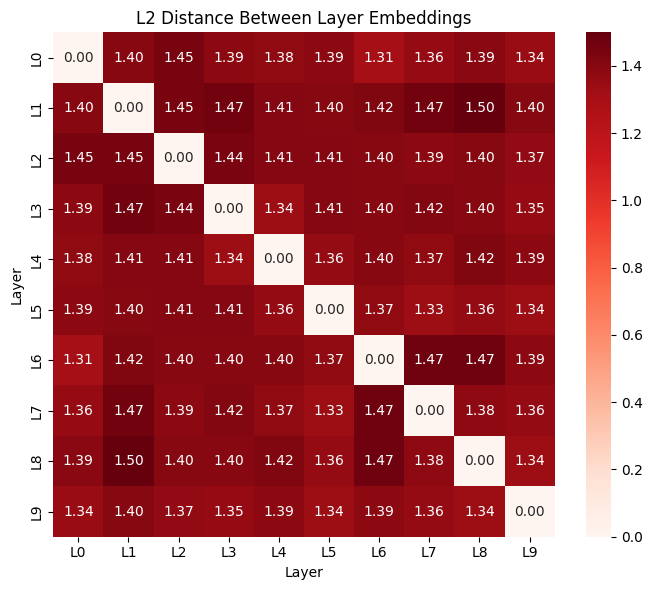

tensor([[0.0000, 1.3956, 1.4513, 1.3874, 1.3764, 1.3854, 1.3072, 1.3588, 1.3921,
         1.3441],
        [1.3956, 0.0000, 1.4516, 1.4672, 1.4089, 1.4019, 1.4226, 1.4678, 1.4995,
         1.4041],
        [1.4513, 1.4516, 0.0000, 1.4409, 1.4100, 1.4094, 1.4000, 1.3870, 1.4027,
         1.3698],
        [1.3874, 1.4672, 1.4409, 0.0000, 1.3389, 1.4106, 1.3991, 1.4152, 1.3975,
         1.3544],
        [1.3764, 1.4089, 1.4100, 1.3389, 0.0000, 1.3632, 1.3970, 1.3737, 1.4192,
         1.3861],
        [1.3854, 1.4019, 1.4094, 1.4106, 1.3632, 0.0000, 1.3712, 1.3350, 1.3621,
         1.3412],
        [1.3072, 1.4226, 1.4000, 1.3991, 1.3970, 1.3712, 0.0000, 1.4745, 1.4706,
         1.3880],
        [1.3588, 1.4678, 1.3870, 1.4152, 1.3737, 1.3350, 1.4745, 0.0000, 1.3774,
         1.3618],
        [1.3921, 1.4995, 1.4027, 1.3975, 1.4192, 1.3621, 1.4706, 1.3774, 0.0000,
         1.3396],
        [1.3441, 1.4041, 1.3698, 1.3544, 1.3861, 1.3412, 1.3880, 1.3618, 1.3396,
         0.0000]])

In [ ]:
l2_distance_heatmap(model)

# Depth Aware Layer Embeddings No Layer Norm, Just Additive - 10k steps

- Eval Perplexity: [Eval @ step 0] Loss: 4.9911, Perplexity: 147.09



[Step 0] Loss: 9.1404 + Reg: -0.023962106555700302
[Step 10] Loss: 7.7721 + Reg: -0.023438259959220886
[Step 20] Loss: 7.2684 + Reg: -0.02507646195590496
[Step 30] Loss: 7.0184 + Reg: -0.02543991431593895
[Step 40] Loss: 7.1136 + Reg: -0.025496041402220726
[Step 50] Loss: 6.9222 + Reg: -0.025280801579356194
[Step 60] Loss: 6.8480 + Reg: -0.025247864425182343
[Step 70] Loss: 6.7968 + Reg: -0.02526603639125824
[Step 80] Loss: 6.8517 + Reg: -0.024966182187199593
[Step 90] Loss: 6.9265 + Reg: -0.02483934536576271
[Step 100] Loss: 6.7291 + Reg: -0.024980420246720314
[Checkpoint] Saved at step 100 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 110] Loss: 6.9086 + Reg: -0.025128833949565887
[Step 120] Loss: 6.6876 + Reg: -0.024971572682261467
[Step 130] Loss: 6.7602 + Reg: -0.024898052215576172
[Step 140] Loss: 6.5797 + Reg: -0.025076068937778473
[Step 150] Loss: 6.6413 + Reg: -0.02500619739294052
[Step 160] Loss: 6.5261 + Reg: -0.025034412741661072
[Step 170] Loss: 6.5901 + Reg: -0.025197509676218033
[Step 180] Loss: 6.4426 + Reg: -0.02478921413421631
[Step 190] Loss: 6.6705 + Reg: -0.024936439469456673
[Step 200] Loss: 6.3129 + Reg: -0.025160059332847595
[Checkpoint] Saved at step 200 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 210] Loss: 6.3134 + Reg: -0.02471231110394001
[Step 220] Loss: 6.4304 + Reg: -0.024822339415550232
[Step 230] Loss: 6.3688 + Reg: -0.02510979026556015
[Step 240] Loss: 6.3436 + Reg: -0.025076840072870255
[Step 250] Loss: 6.2579 + Reg: -0.025288693606853485
[Step 260] Loss: 6.5003 + Reg: -0.025066865608096123
[Step 270] Loss: 6.4899 + Reg: -0.02476123720407486
[Step 280] Loss: 6.2690 + Reg: -0.025248348712921143
[Step 290] Loss: 6.1142 + Reg: -0.02472979947924614
[Step 300] Loss: 6.1544 + Reg: -0.025055930018424988
[Checkpoint] Saved at step 300 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 310] Loss: 6.1689 + Reg: -0.025010760873556137
[Step 320] Loss: 6.3668 + Reg: -0.025288907811045647
[Step 330] Loss: 6.1264 + Reg: -0.02519948221743107
[Step 340] Loss: 6.6451 + Reg: -0.025137372314929962
[Step 350] Loss: 6.2196 + Reg: -0.02521231397986412
[Step 360] Loss: 6.5999 + Reg: -0.02501804381608963
[Step 370] Loss: 6.1525 + Reg: -0.025053756311535835
[Step 380] Loss: 6.0368 + Reg: -0.02521228976547718
[Step 390] Loss: 6.2307 + Reg: -0.025136856362223625
[Step 400] Loss: 6.0895 + Reg: -0.025012705475091934
[Checkpoint] Saved at step 400 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 410] Loss: 6.3771 + Reg: -0.025242356583476067
[Step 420] Loss: 6.1421 + Reg: -0.025321807712316513
[Step 430] Loss: 6.1502 + Reg: -0.025173410773277283
[Step 440] Loss: 6.0065 + Reg: -0.025279788300395012
[Step 450] Loss: 6.1394 + Reg: -0.025251954793930054
[Step 460] Loss: 6.2681 + Reg: -0.025080613791942596
[Step 470] Loss: 6.0467 + Reg: -0.025221556425094604
[Step 480] Loss: 5.8986 + Reg: -0.025080036371946335
[Step 490] Loss: 5.9918 + Reg: -0.02531539462506771
[Step 500] Loss: 5.8878 + Reg: -0.025135742500424385
[Checkpoint] Saved at step 500 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 510] Loss: 6.1786 + Reg: -0.02510523796081543
[Step 520] Loss: 6.0310 + Reg: -0.025229092687368393
[Step 530] Loss: 6.0121 + Reg: -0.02509530447423458
[Step 540] Loss: 5.8392 + Reg: -0.025022685527801514
[Step 550] Loss: 6.0452 + Reg: -0.02527201548218727
[Step 560] Loss: 5.8798 + Reg: -0.025232812389731407
[Step 570] Loss: 5.9687 + Reg: -0.025125989690423012
[Step 580] Loss: 5.8133 + Reg: -0.025247277691960335
[Step 590] Loss: 5.9142 + Reg: -0.02531304582953453
[Step 600] Loss: 6.0943 + Reg: -0.025173945352435112
[Checkpoint] Saved at step 600 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 610] Loss: 5.9860 + Reg: -0.025378379970788956
[Step 620] Loss: 5.9790 + Reg: -0.025287624448537827
[Step 630] Loss: 5.8625 + Reg: -0.025339776650071144
[Step 640] Loss: 5.8562 + Reg: -0.02528737299144268
[Step 650] Loss: 6.2417 + Reg: -0.02500937320291996
[Step 660] Loss: 5.8572 + Reg: -0.02521328628063202
[Step 670] Loss: 5.8065 + Reg: -0.025243882089853287
[Step 680] Loss: 6.2418 + Reg: -0.024848541244864464
[Step 690] Loss: 5.9172 + Reg: -0.025073833763599396
[Step 700] Loss: 5.9345 + Reg: -0.02520165406167507
[Checkpoint] Saved at step 700 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 710] Loss: 5.8513 + Reg: -0.0251170564442873
[Step 720] Loss: 5.7934 + Reg: -0.02531922608613968
[Step 730] Loss: 6.0697 + Reg: -0.025161804631352425
[Step 740] Loss: 6.0305 + Reg: -0.025246748700737953
[Step 750] Loss: 5.8536 + Reg: -0.0252419114112854
[Step 760] Loss: 5.9376 + Reg: -0.025146393105387688
[Step 770] Loss: 6.4933 + Reg: -0.025071552023291588
[Step 780] Loss: 5.7718 + Reg: -0.025329092517495155
[Step 790] Loss: 5.9517 + Reg: -0.02529839240014553
[Step 800] Loss: 6.0253 + Reg: -0.025022460147738457
[Checkpoint] Saved at step 800 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 810] Loss: 6.3311 + Reg: -0.024994663894176483
[Step 820] Loss: 6.4918 + Reg: -0.02498704381287098
[Step 830] Loss: 6.1042 + Reg: -0.025191301479935646
[Step 840] Loss: 5.9707 + Reg: -0.02516893297433853
[Step 850] Loss: 5.8397 + Reg: -0.025072846561670303
[Step 860] Loss: 6.2103 + Reg: -0.024899641051888466
[Step 870] Loss: 5.8563 + Reg: -0.0251680389046669
[Step 880] Loss: 5.7881 + Reg: -0.025265024974942207
[Step 890] Loss: 5.8727 + Reg: -0.025288015604019165
[Step 900] Loss: 6.0149 + Reg: -0.0249775443226099
[Checkpoint] Saved at step 900 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 910] Loss: 5.8446 + Reg: -0.024573273956775665
[Step 920] Loss: 5.9368 + Reg: -0.02491752803325653
[Step 930] Loss: 5.8750 + Reg: -0.02528032287955284
[Step 940] Loss: 5.8951 + Reg: -0.025298846885561943
[Step 950] Loss: 5.8448 + Reg: -0.025230279192328453
[Step 960] Loss: 5.8822 + Reg: -0.025168107822537422
[Step 970] Loss: 5.7984 + Reg: -0.025260167196393013
[Step 980] Loss: 6.0471 + Reg: -0.025011321529746056
[Step 990] Loss: 5.6205 + Reg: -0.025083402171730995
[Step 1000] Loss: 6.0238 + Reg: -0.025061389431357384
[Checkpoint] Saved at step 1000 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1010] Loss: 5.7719 + Reg: -0.02533061057329178
[Step 1020] Loss: 5.7993 + Reg: -0.02511611394584179
[Step 1030] Loss: 5.6665 + Reg: -0.025246715173125267
[Step 1040] Loss: 5.7995 + Reg: -0.025180920958518982
[Step 1050] Loss: 5.6394 + Reg: -0.025104636326432228
[Step 1060] Loss: 5.9045 + Reg: -0.025222204625606537
[Step 1070] Loss: 5.7757 + Reg: -0.025148725137114525
[Step 1080] Loss: 5.8378 + Reg: -0.025256693363189697
[Step 1090] Loss: 5.8346 + Reg: -0.02535047009587288
[Step 1100] Loss: 5.9895 + Reg: -0.025040587410330772
[Checkpoint] Saved at step 1100 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1110] Loss: 5.7480 + Reg: -0.025274137035012245
[Step 1120] Loss: 5.7913 + Reg: -0.025285763666033745
[Step 1130] Loss: 5.7869 + Reg: -0.02518937923014164
[Step 1140] Loss: 5.8411 + Reg: -0.025349123403429985
[Step 1150] Loss: 5.7347 + Reg: -0.025119537487626076
[Step 1160] Loss: 5.8100 + Reg: -0.02546640858054161
[Step 1170] Loss: 5.8936 + Reg: -0.025416536256670952
[Step 1180] Loss: 5.7717 + Reg: -0.02523959055542946
[Step 1190] Loss: 5.7086 + Reg: -0.025155527517199516
[Step 1200] Loss: 5.6844 + Reg: -0.02527943067252636
[Checkpoint] Saved at step 1200 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1210] Loss: 5.7083 + Reg: -0.02527664788067341
[Step 1220] Loss: 5.9764 + Reg: -0.025288529694080353
[Step 1230] Loss: 5.9058 + Reg: -0.024704815819859505
[Step 1240] Loss: 5.6570 + Reg: -0.025220265612006187
[Step 1250] Loss: 5.7630 + Reg: -0.02537323348224163
[Step 1260] Loss: 5.8055 + Reg: -0.02524602599442005
[Step 1270] Loss: 5.8215 + Reg: -0.025157198309898376
[Step 1280] Loss: 5.8654 + Reg: -0.02529478818178177
[Step 1290] Loss: 5.7070 + Reg: -0.025136474519968033
[Step 1300] Loss: 5.6976 + Reg: -0.02537488378584385
[Checkpoint] Saved at step 1300 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1310] Loss: 5.5495 + Reg: -0.02534322626888752
[Step 1320] Loss: 5.9155 + Reg: -0.02513096295297146
[Step 1330] Loss: 5.5954 + Reg: -0.02537248469889164
[Step 1340] Loss: 5.7620 + Reg: -0.025364577770233154
[Step 1350] Loss: 5.6678 + Reg: -0.025116700679063797
[Step 1360] Loss: 5.6553 + Reg: -0.025291290134191513
[Step 1370] Loss: 5.8750 + Reg: -0.025324271991848946
[Step 1380] Loss: 5.7591 + Reg: -0.02540239319205284
[Step 1390] Loss: 5.6535 + Reg: -0.02527119591832161
[Step 1400] Loss: 5.7236 + Reg: -0.025097152218222618
[Checkpoint] Saved at step 1400 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1410] Loss: 5.7002 + Reg: -0.02532515488564968
[Step 1420] Loss: 5.6506 + Reg: -0.025384800508618355
[Step 1430] Loss: 5.7662 + Reg: -0.025454210117459297
[Step 1440] Loss: 5.9561 + Reg: -0.025370251387357712
[Step 1450] Loss: 5.7621 + Reg: -0.025394000113010406
[Step 1460] Loss: 5.7966 + Reg: -0.025259898975491524
[Step 1470] Loss: 5.5609 + Reg: -0.025215119123458862
[Step 1480] Loss: 5.6794 + Reg: -0.025382041931152344
[Step 1490] Loss: 5.6008 + Reg: -0.025334499776363373
[Step 1500] Loss: 5.8377 + Reg: -0.02544332481920719
[Checkpoint] Saved at step 1500 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1510] Loss: 5.7508 + Reg: -0.025368360802531242
[Step 1520] Loss: 5.7775 + Reg: -0.02532896026968956
[Step 1530] Loss: 5.7243 + Reg: -0.025196101516485214
[Step 1540] Loss: 5.5409 + Reg: -0.025394290685653687
[Step 1550] Loss: 5.4208 + Reg: -0.025233259424567223
[Step 1560] Loss: 5.6327 + Reg: -0.02530023083090782
[Step 1570] Loss: 5.6216 + Reg: -0.025329556316137314
[Step 1580] Loss: 5.9011 + Reg: -0.02542940340936184
[Step 1590] Loss: 5.4293 + Reg: -0.025224093347787857
[Step 1600] Loss: 5.8055 + Reg: -0.02524789795279503
[Checkpoint] Saved at step 1600 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1610] Loss: 5.6521 + Reg: -0.025401992723345757
[Step 1620] Loss: 5.7955 + Reg: -0.0250559039413929
[Step 1630] Loss: 5.3305 + Reg: -0.025446653366088867
[Step 1640] Loss: 5.6926 + Reg: -0.025399697944521904
[Step 1650] Loss: 5.5282 + Reg: -0.025247888639569283
[Step 1660] Loss: 5.4378 + Reg: -0.025317886844277382
[Step 1670] Loss: 5.4733 + Reg: -0.025286974385380745
[Step 1680] Loss: 5.6509 + Reg: -0.025196442380547523
[Step 1690] Loss: 5.5895 + Reg: -0.025283392518758774
[Step 1700] Loss: 5.5169 + Reg: -0.025395333766937256
[Checkpoint] Saved at step 1700 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1710] Loss: 5.7520 + Reg: -0.025461267679929733
[Step 1720] Loss: 5.5910 + Reg: -0.025423835963010788
[Step 1730] Loss: 5.6892 + Reg: -0.02546197548508644
[Step 1740] Loss: 5.4975 + Reg: -0.025430001318454742
[Step 1750] Loss: 5.6557 + Reg: -0.025379208847880363
[Step 1760] Loss: 5.6747 + Reg: -0.025408633053302765
[Step 1770] Loss: 5.8175 + Reg: -0.025422248989343643
[Step 1780] Loss: 5.5032 + Reg: -0.02517973817884922
[Step 1790] Loss: 5.5030 + Reg: -0.025399215519428253
[Step 1800] Loss: 5.6109 + Reg: -0.02535589225590229
[Checkpoint] Saved at step 1800 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1810] Loss: 5.7986 + Reg: -0.025412768125534058
[Step 1820] Loss: 5.5708 + Reg: -0.025317545980215073
[Step 1830] Loss: 5.6932 + Reg: -0.025239501148462296
[Step 1840] Loss: 5.5174 + Reg: -0.025347858667373657
[Step 1850] Loss: 5.5176 + Reg: -0.02528577484190464
[Step 1860] Loss: 5.6425 + Reg: -0.025191854685544968
[Step 1870] Loss: 5.5849 + Reg: -0.02537587098777294
[Step 1880] Loss: 5.4872 + Reg: -0.025362733751535416
[Step 1890] Loss: 5.7211 + Reg: -0.02516786940395832
[Step 1900] Loss: 5.7229 + Reg: -0.025087667629122734
[Checkpoint] Saved at step 1900 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1910] Loss: 5.6927 + Reg: -0.02544659748673439
[Step 1920] Loss: 5.5952 + Reg: -0.02538105472922325
[Step 1930] Loss: 5.6151 + Reg: -0.025321459397673607
[Step 1940] Loss: 5.6773 + Reg: -0.025431768968701363
[Step 1950] Loss: 5.5690 + Reg: -0.025397131219506264
[Step 1960] Loss: 5.7121 + Reg: -0.02524937130510807
[Step 1970] Loss: 5.3744 + Reg: -0.025337696075439453
[Step 1980] Loss: 5.5686 + Reg: -0.025377541780471802
[Step 1990] Loss: 5.5633 + Reg: -0.02531568892300129
[Step 2000] Loss: 5.5670 + Reg: -0.025457991287112236
[Checkpoint] Saved at step 2000 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2010] Loss: 5.6179 + Reg: -0.025309070944786072
[Step 2020] Loss: 5.5630 + Reg: -0.025265689939260483
[Step 2030] Loss: 5.6098 + Reg: -0.025380706414580345
[Step 2040] Loss: 5.4925 + Reg: -0.02533648908138275
[Step 2050] Loss: 5.6168 + Reg: -0.02533247321844101
[Step 2060] Loss: 5.5826 + Reg: -0.025338444858789444
[Step 2070] Loss: 5.3069 + Reg: -0.025376413017511368
[Step 2080] Loss: 5.6101 + Reg: -0.025416504591703415
[Step 2090] Loss: 5.6275 + Reg: -0.025400489568710327
[Step 2100] Loss: 5.5587 + Reg: -0.025372441858053207
[Checkpoint] Saved at step 2100 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2110] Loss: 5.6239 + Reg: -0.025284714996814728
[Step 2120] Loss: 5.5569 + Reg: -0.025261079892516136
[Step 2130] Loss: 5.7211 + Reg: -0.025092756375670433
[Step 2140] Loss: 5.7462 + Reg: -0.025178322568535805
[Step 2150] Loss: 5.5977 + Reg: -0.025348318740725517
[Step 2160] Loss: 5.6140 + Reg: -0.02525133080780506
[Step 2170] Loss: 5.6210 + Reg: -0.025343988090753555
[Step 2180] Loss: 5.5034 + Reg: -0.025433670729398727
[Step 2190] Loss: 5.4089 + Reg: -0.025320064276456833
[Step 2200] Loss: 5.4506 + Reg: -0.025501936674118042
[Checkpoint] Saved at step 2200 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2210] Loss: 5.5533 + Reg: -0.0254049152135849
[Step 2220] Loss: 5.5087 + Reg: -0.02533620037138462
[Step 2230] Loss: 5.5278 + Reg: -0.025482796132564545
[Step 2240] Loss: 5.3937 + Reg: -0.02540186047554016
[Step 2250] Loss: 5.4984 + Reg: -0.02517818845808506
[Step 2260] Loss: 5.3662 + Reg: -0.025409482419490814
[Step 2270] Loss: 5.4269 + Reg: -0.02547912299633026
[Step 2280] Loss: 5.4613 + Reg: -0.025012454017996788
[Step 2290] Loss: 5.6228 + Reg: -0.025460364297032356
[Step 2300] Loss: 5.3359 + Reg: -0.02553344890475273
[Checkpoint] Saved at step 2300 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2310] Loss: 5.6578 + Reg: -0.02539992332458496
[Step 2320] Loss: 5.6329 + Reg: -0.02540970966219902
[Step 2330] Loss: 5.3726 + Reg: -0.025395266711711884
[Step 2340] Loss: 5.6332 + Reg: -0.02539963461458683
[Step 2350] Loss: 5.0799 + Reg: -0.025408344343304634
[Step 2360] Loss: 5.5031 + Reg: -0.02512454055249691
[Step 2370] Loss: 5.6676 + Reg: -0.025257252156734467
[Step 2380] Loss: 5.9222 + Reg: -0.02516677789390087
[Step 2390] Loss: 5.7042 + Reg: -0.025435015559196472
[Step 2400] Loss: 5.4664 + Reg: -0.02533390372991562
[Checkpoint] Saved at step 2400 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2410] Loss: 5.4535 + Reg: -0.025298042222857475
[Step 2420] Loss: 5.4707 + Reg: -0.025404611602425575
[Step 2430] Loss: 5.4211 + Reg: -0.02539912238717079
[Step 2440] Loss: 5.5457 + Reg: -0.025504184886813164
[Step 2450] Loss: 5.2725 + Reg: -0.025465283542871475
[Step 2460] Loss: 5.4521 + Reg: -0.025468582287430763
[Step 2470] Loss: 5.8600 + Reg: -0.025411853566765785
[Step 2480] Loss: 5.4984 + Reg: -0.02544601634144783
[Step 2490] Loss: 5.5272 + Reg: -0.025489171966910362
[Step 2500] Loss: 5.5347 + Reg: -0.025379300117492676
[Checkpoint] Saved at step 2500 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2510] Loss: 5.5461 + Reg: -0.025253184139728546
[Step 2520] Loss: 5.5763 + Reg: -0.025367433205246925
[Step 2530] Loss: 5.5524 + Reg: -0.02542281523346901
[Step 2540] Loss: 5.5305 + Reg: -0.025376034900546074
[Step 2550] Loss: 5.4495 + Reg: -0.02536063827574253
[Step 2560] Loss: 5.6070 + Reg: -0.025271667167544365
[Step 2570] Loss: 5.2894 + Reg: -0.025381578132510185
[Step 2580] Loss: 5.4786 + Reg: -0.02538342960178852
[Step 2590] Loss: 5.3978 + Reg: -0.025332428514957428
[Step 2600] Loss: 5.4741 + Reg: -0.025032760575413704
[Checkpoint] Saved at step 2600 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2610] Loss: 5.3952 + Reg: -0.025349030271172523
[Step 2620] Loss: 5.4895 + Reg: -0.025374438613653183
[Step 2630] Loss: 5.5682 + Reg: -0.025320397689938545
[Step 2640] Loss: 5.5620 + Reg: -0.025353791192173958
[Step 2650] Loss: 5.4740 + Reg: -0.02530001290142536
[Step 2660] Loss: 5.3731 + Reg: -0.02544882521033287
[Step 2670] Loss: 5.4536 + Reg: -0.0254531092941761
[Step 2680] Loss: 5.4421 + Reg: -0.025476431474089622
[Step 2690] Loss: 5.3931 + Reg: -0.025397280231118202
[Step 2700] Loss: 5.3689 + Reg: -0.025335559621453285
[Checkpoint] Saved at step 2700 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2710] Loss: 5.4650 + Reg: -0.02516166679561138
[Step 2720] Loss: 5.5001 + Reg: -0.025342315435409546
[Step 2730] Loss: 5.4215 + Reg: -0.025495173409581184
[Step 2740] Loss: 5.2774 + Reg: -0.025432122871279716
[Step 2750] Loss: 5.3290 + Reg: -0.0255357027053833
[Step 2760] Loss: 5.5918 + Reg: -0.02540009468793869
[Step 2770] Loss: 5.3903 + Reg: -0.025533894076943398
[Step 2780] Loss: 5.3389 + Reg: -0.025321776047348976
[Step 2790] Loss: 5.3060 + Reg: -0.025495490059256554
[Step 2800] Loss: 5.6764 + Reg: -0.025484513491392136
[Checkpoint] Saved at step 2800 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2810] Loss: 5.5103 + Reg: -0.02550729177892208
[Step 2820] Loss: 5.4012 + Reg: -0.02540540136396885
[Step 2830] Loss: 5.2019 + Reg: -0.02545485459268093
[Step 2840] Loss: 5.7048 + Reg: -0.025356164202094078
[Step 2850] Loss: 5.4430 + Reg: -0.025515947490930557
[Step 2860] Loss: 5.5775 + Reg: -0.025072006508708
[Step 2870] Loss: 5.3799 + Reg: -0.02534729614853859
[Step 2880] Loss: 5.5415 + Reg: -0.025358447805047035
[Step 2890] Loss: 5.6015 + Reg: -0.02499259263277054
[Step 2900] Loss: 5.2373 + Reg: -0.02546597830951214
[Checkpoint] Saved at step 2900 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2910] Loss: 5.5303 + Reg: -0.025253240019083023
[Step 2920] Loss: 5.2506 + Reg: -0.025390420109033585
[Step 2930] Loss: 5.2383 + Reg: -0.02541857212781906
[Step 2940] Loss: 5.3918 + Reg: -0.025490565225481987
[Step 2950] Loss: 5.4230 + Reg: -0.025357956066727638
[Step 2960] Loss: 5.5091 + Reg: -0.025051383301615715
[Step 2970] Loss: 5.3084 + Reg: -0.025442561134696007
[Step 2980] Loss: 5.3440 + Reg: -0.02531539835035801
[Step 2990] Loss: 5.4534 + Reg: -0.025337213650345802
[Step 3000] Loss: 5.4415 + Reg: -0.02509916201233864
[Checkpoint] Saved at step 3000 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3010] Loss: 5.2890 + Reg: -0.025460585951805115
[Step 3020] Loss: 5.5186 + Reg: -0.025401029735803604
[Step 3030] Loss: 5.4664 + Reg: -0.025487184524536133
[Step 3040] Loss: 5.4609 + Reg: -0.025395968928933144
[Step 3050] Loss: 5.3483 + Reg: -0.025420717895030975
[Step 3060] Loss: 5.1492 + Reg: -0.025363974273204803
[Step 3070] Loss: 5.2244 + Reg: -0.02552971988916397
[Step 3080] Loss: 5.3503 + Reg: -0.025340983644127846
[Step 3090] Loss: 5.3718 + Reg: -0.025448596104979515
[Step 3100] Loss: 5.5306 + Reg: -0.025270409882068634
[Checkpoint] Saved at step 3100 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3110] Loss: 5.4128 + Reg: -0.025497345253825188
[Step 3120] Loss: 5.5187 + Reg: -0.025502197444438934
[Step 3130] Loss: 5.5178 + Reg: -0.025437135249376297
[Step 3140] Loss: 5.2851 + Reg: -0.025468571111559868
[Step 3150] Loss: 5.4879 + Reg: -0.0252432432025671
[Step 3160] Loss: 5.3471 + Reg: -0.025328755378723145
[Step 3170] Loss: 5.3007 + Reg: -0.02555670216679573
[Step 3180] Loss: 5.4279 + Reg: -0.02541019208729267
[Step 3190] Loss: 5.6035 + Reg: -0.025264952331781387
[Step 3200] Loss: 5.0950 + Reg: -0.025483012199401855
[Checkpoint] Saved at step 3200 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3210] Loss: 5.3922 + Reg: -0.025340894237160683
[Step 3220] Loss: 5.4281 + Reg: -0.02539159171283245
[Step 3230] Loss: 5.5301 + Reg: -0.02552526444196701
[Step 3240] Loss: 5.3471 + Reg: -0.025484366342425346
[Step 3250] Loss: 5.2793 + Reg: -0.02534753829240799
[Step 3260] Loss: 5.4145 + Reg: -0.025407928973436356
[Step 3270] Loss: 5.4985 + Reg: -0.0252451840788126
[Step 3280] Loss: 5.2483 + Reg: -0.025411929935216904
[Step 3290] Loss: 5.4356 + Reg: -0.025309821590781212
[Step 3300] Loss: 5.2404 + Reg: -0.025478439405560493
[Checkpoint] Saved at step 3300 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3310] Loss: 5.4252 + Reg: -0.025529732927680016
[Step 3320] Loss: 5.4772 + Reg: -0.025271562859416008
[Step 3330] Loss: 5.5554 + Reg: -0.02520306035876274
[Step 3340] Loss: 5.2872 + Reg: -0.02541620284318924
[Step 3350] Loss: 5.4757 + Reg: -0.02552848495543003
[Step 3360] Loss: 5.0893 + Reg: -0.02552783489227295
[Step 3370] Loss: 5.3895 + Reg: -0.02551467902958393
[Step 3380] Loss: 5.3656 + Reg: -0.025380991399288177
[Step 3390] Loss: 5.4381 + Reg: -0.025381306186318398
[Step 3400] Loss: 5.5105 + Reg: -0.025400733575224876
[Checkpoint] Saved at step 3400 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3410] Loss: 5.5438 + Reg: -0.025536498054862022
[Step 3420] Loss: 5.2543 + Reg: -0.025436753407120705
[Step 3430] Loss: 5.6031 + Reg: -0.025553278625011444
[Step 3440] Loss: 5.4031 + Reg: -0.025373263284564018
[Step 3450] Loss: 5.3015 + Reg: -0.02544836513698101
[Step 3460] Loss: 5.2417 + Reg: -0.025256279855966568
[Step 3470] Loss: 5.3677 + Reg: -0.025530705228447914
[Step 3480] Loss: 5.3013 + Reg: -0.025500595569610596
[Step 3490] Loss: 5.3407 + Reg: -0.02532985620200634
[Step 3500] Loss: 5.2812 + Reg: -0.02546551637351513
[Checkpoint] Saved at step 3500 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3510] Loss: 5.3663 + Reg: -0.025374025106430054
[Step 3520] Loss: 5.1944 + Reg: -0.025525497272610664
[Step 3530] Loss: 5.1180 + Reg: -0.025336483493447304
[Step 3540] Loss: 5.4693 + Reg: -0.02545158378779888
[Step 3550] Loss: 5.1455 + Reg: -0.02550427056849003
[Step 3560] Loss: 5.3595 + Reg: -0.025375213474035263
[Step 3570] Loss: 5.4024 + Reg: -0.025434087961912155
[Step 3580] Loss: 5.2121 + Reg: -0.025389542803168297
[Step 3590] Loss: 5.1571 + Reg: -0.025406472384929657
[Step 3600] Loss: 5.1839 + Reg: -0.025442013517022133
[Checkpoint] Saved at step 3600 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3610] Loss: 5.3464 + Reg: -0.025492407381534576
[Step 3620] Loss: 5.3517 + Reg: -0.025346018373966217
[Step 3630] Loss: 5.3135 + Reg: -0.025483382865786552
[Step 3640] Loss: 5.4585 + Reg: -0.025319775566458702
[Step 3650] Loss: 5.3576 + Reg: -0.025194883346557617
[Step 3660] Loss: 5.1572 + Reg: -0.025555824860930443
[Step 3670] Loss: 5.7606 + Reg: -0.02544744871556759
[Step 3680] Loss: 5.3297 + Reg: -0.025384042412042618
[Step 3690] Loss: 5.3916 + Reg: -0.025294104591012
[Step 3700] Loss: 5.3447 + Reg: -0.025454344227910042
[Checkpoint] Saved at step 3700 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3710] Loss: 5.1551 + Reg: -0.02550489455461502
[Step 3720] Loss: 5.2194 + Reg: -0.025437980890274048
[Step 3730] Loss: 5.3990 + Reg: -0.02517111785709858
[Step 3740] Loss: 5.1146 + Reg: -0.025319039821624756
[Step 3750] Loss: 5.3181 + Reg: -0.025428619235754013
[Step 3760] Loss: 5.3643 + Reg: -0.025395341217517853
[Step 3770] Loss: 5.3127 + Reg: -0.025275148451328278
[Step 3780] Loss: 5.3897 + Reg: -0.02535366266965866
[Step 3790] Loss: 5.3405 + Reg: -0.0255326796323061
[Step 3800] Loss: 5.3442 + Reg: -0.02545066922903061
[Checkpoint] Saved at step 3800 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3810] Loss: 5.3396 + Reg: -0.025099383667111397
[Step 3820] Loss: 5.1682 + Reg: -0.025499548763036728
[Step 3830] Loss: 5.2440 + Reg: -0.025375552475452423
[Step 3840] Loss: 5.2476 + Reg: -0.02545894868671894
[Step 3850] Loss: 5.3985 + Reg: -0.025013932958245277
[Step 3860] Loss: 5.5396 + Reg: -0.025441188365221024
[Step 3870] Loss: 5.3713 + Reg: -0.025450527667999268
[Step 3880] Loss: 5.4089 + Reg: -0.025265207514166832
[Step 3890] Loss: 5.2508 + Reg: -0.025294644758105278
[Step 3900] Loss: 5.0475 + Reg: -0.02545025199651718
[Checkpoint] Saved at step 3900 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3910] Loss: 5.3124 + Reg: -0.025334404781460762
[Step 3920] Loss: 5.3280 + Reg: -0.025470713153481483
[Step 3930] Loss: 5.1554 + Reg: -0.02544487453997135
[Step 3940] Loss: 5.3229 + Reg: -0.0252918042242527
[Step 3950] Loss: 5.2659 + Reg: -0.025458909571170807
[Step 3960] Loss: 5.4331 + Reg: -0.025540295988321304
[Step 3970] Loss: 5.1880 + Reg: -0.025167090818285942
[Step 3980] Loss: 5.0017 + Reg: -0.025555308908224106
[Step 3990] Loss: 5.0959 + Reg: -0.025572599843144417
[Step 4000] Loss: 5.2684 + Reg: -0.02536291629076004
[Checkpoint] Saved at step 4000 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4010] Loss: 5.4645 + Reg: -0.025404026731848717
[Step 4020] Loss: 5.2615 + Reg: -0.025452574715018272
[Step 4030] Loss: 5.1872 + Reg: -0.025395167991518974
[Step 4040] Loss: 5.2087 + Reg: -0.02543548494577408
[Step 4050] Loss: 5.4273 + Reg: -0.025178654119372368
[Step 4060] Loss: 5.1910 + Reg: -0.025377606973052025
[Step 4070] Loss: 5.2377 + Reg: -0.02544168382883072
[Step 4080] Loss: 5.2738 + Reg: -0.025187315419316292
[Step 4090] Loss: 5.3002 + Reg: -0.025538166984915733
[Step 4100] Loss: 5.3953 + Reg: -0.025422625243663788
[Checkpoint] Saved at step 4100 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4110] Loss: 5.3982 + Reg: -0.025180211290717125
[Step 4120] Loss: 5.2792 + Reg: -0.025445036590099335
[Step 4130] Loss: 5.1742 + Reg: -0.025319764390587807
[Step 4140] Loss: 5.3604 + Reg: -0.025398505851626396
[Step 4150] Loss: 5.1397 + Reg: -0.02550218440592289
[Step 4160] Loss: 5.1866 + Reg: -0.025491051375865936
[Step 4170] Loss: 5.0897 + Reg: -0.025496136397123337
[Step 4180] Loss: 5.3973 + Reg: -0.02550370618700981
[Step 4190] Loss: 5.3031 + Reg: -0.025432681664824486
[Step 4200] Loss: 5.1576 + Reg: -0.02542848512530327
[Checkpoint] Saved at step 4200 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4210] Loss: 5.2564 + Reg: -0.025383923202753067
[Step 4220] Loss: 5.1484 + Reg: -0.025491097941994667
[Step 4230] Loss: 5.4744 + Reg: -0.02509196847677231
[Step 4240] Loss: 5.2942 + Reg: -0.025559328496456146
[Step 4250] Loss: 5.7644 + Reg: -0.02529999241232872
[Step 4260] Loss: 4.9788 + Reg: -0.02553940750658512
[Step 4270] Loss: 5.3677 + Reg: -0.025316914543509483
[Step 4280] Loss: 5.1118 + Reg: -0.025544900447130203
[Step 4290] Loss: 5.2044 + Reg: -0.025396494194865227
[Step 4300] Loss: 5.1650 + Reg: -0.025321943685412407
[Checkpoint] Saved at step 4300 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4310] Loss: 5.3275 + Reg: -0.02545359544456005
[Step 4320] Loss: 5.2656 + Reg: -0.02555472031235695
[Step 4330] Loss: 5.0928 + Reg: -0.02538728155195713
[Step 4340] Loss: 5.1904 + Reg: -0.02535741589963436
[Step 4350] Loss: 5.3962 + Reg: -0.025341438129544258
[Step 4360] Loss: 5.4108 + Reg: -0.02548936754465103
[Step 4370] Loss: 5.2895 + Reg: -0.025377284735441208
[Step 4380] Loss: 5.1464 + Reg: -0.02548474259674549
[Step 4390] Loss: 5.2291 + Reg: -0.025380942970514297
[Step 4400] Loss: 5.1061 + Reg: -0.025531597435474396
[Checkpoint] Saved at step 4400 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4410] Loss: 5.2170 + Reg: -0.025366008281707764
[Step 4420] Loss: 5.2332 + Reg: -0.02544645220041275
[Step 4430] Loss: 5.3635 + Reg: -0.025201959535479546
[Step 4440] Loss: 5.2280 + Reg: -0.02545074373483658
[Step 4450] Loss: 5.2218 + Reg: -0.02533404715359211
[Step 4460] Loss: 5.2520 + Reg: -0.025356797501444817
[Step 4470] Loss: 5.6028 + Reg: -0.025337032973766327
[Step 4480] Loss: 4.9513 + Reg: -0.025528907775878906
[Step 4490] Loss: 5.2039 + Reg: -0.025442643091082573
[Step 4500] Loss: 5.1942 + Reg: -0.02541005052626133
[Checkpoint] Saved at step 4500 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4510] Loss: 5.2485 + Reg: -0.025432350113987923
[Step 4520] Loss: 5.3357 + Reg: -0.02545151486992836
[Step 4530] Loss: 5.3307 + Reg: -0.02545023337006569
[Step 4540] Loss: 5.3178 + Reg: -0.025495726615190506
[Step 4550] Loss: 5.3409 + Reg: -0.025405220687389374
[Step 4560] Loss: 5.2304 + Reg: -0.02557206340134144
[Step 4570] Loss: 5.3835 + Reg: -0.025423118844628334
[Step 4580] Loss: 5.0470 + Reg: -0.02545318566262722
[Step 4590] Loss: 5.2473 + Reg: -0.02541452832520008
[Step 4600] Loss: 5.1928 + Reg: -0.025499194860458374
[Checkpoint] Saved at step 4600 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4610] Loss: 4.8065 + Reg: -0.025525707751512527
[Step 4620] Loss: 5.2467 + Reg: -0.025533122941851616
[Step 4630] Loss: 5.2664 + Reg: -0.02549629472196102
[Step 4640] Loss: 5.1231 + Reg: -0.025368941947817802
[Step 4650] Loss: 5.2696 + Reg: -0.02547336369752884
[Step 4660] Loss: 5.1779 + Reg: -0.025474824011325836
[Step 4670] Loss: 5.0461 + Reg: -0.025457659736275673
[Step 4680] Loss: 5.3155 + Reg: -0.025415517389774323
[Step 4690] Loss: 5.1481 + Reg: -0.025542056187987328
[Step 4700] Loss: 5.1323 + Reg: -0.025401033461093903
[Checkpoint] Saved at step 4700 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4710] Loss: 5.0666 + Reg: -0.02536996267735958
[Step 4720] Loss: 5.3545 + Reg: -0.025423429906368256
[Step 4730] Loss: 5.3011 + Reg: -0.02555350959300995
[Step 4740] Loss: 4.9552 + Reg: -0.025525160133838654
[Step 4750] Loss: 5.3774 + Reg: -0.025375375524163246
[Step 4760] Loss: 5.1929 + Reg: -0.025381645187735558
[Step 4770] Loss: 5.2108 + Reg: -0.025497160851955414
[Step 4780] Loss: 5.3193 + Reg: -0.025269918143749237
[Step 4790] Loss: 5.4942 + Reg: -0.025219468399882317
[Step 4800] Loss: 5.2559 + Reg: -0.02544233202934265
[Checkpoint] Saved at step 4800 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4810] Loss: 5.1198 + Reg: -0.025564605370163918
[Step 4820] Loss: 5.0926 + Reg: -0.025431590154767036
[Step 4830] Loss: 5.2058 + Reg: -0.02537318877875805
[Step 4840] Loss: 5.0819 + Reg: -0.025445422157645226
[Step 4850] Loss: 5.1340 + Reg: -0.025264382362365723
[Step 4860] Loss: 5.1985 + Reg: -0.025484232231974602
[Step 4870] Loss: 5.2004 + Reg: -0.02519374154508114
[Step 4880] Loss: 5.2435 + Reg: -0.025495342910289764
[Step 4890] Loss: 5.2974 + Reg: -0.025431163609027863
[Step 4900] Loss: 5.0750 + Reg: -0.025585340335965157
[Checkpoint] Saved at step 4900 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4910] Loss: 5.4415 + Reg: -0.025404464453458786
[Step 4920] Loss: 5.1865 + Reg: -0.025393394753336906
[Step 4930] Loss: 5.4809 + Reg: -0.02544322982430458
[Step 4940] Loss: 5.1549 + Reg: -0.025491075590252876
[Step 4950] Loss: 5.2723 + Reg: -0.025495806708931923
[Step 4960] Loss: 5.4574 + Reg: -0.025328848510980606
[Step 4970] Loss: 5.1988 + Reg: -0.02540399879217148
[Step 4980] Loss: 5.2370 + Reg: -0.025485115125775337
[Step 4990] Loss: 5.0684 + Reg: -0.025356344878673553
[Step 0] Loss: 5.2617 + Reg: -0.025539318099617958
[Step 10] Loss: 5.1374 + Reg: -0.025560159236192703
[Step 20] Loss: 4.8519 + Reg: -0.02557719126343727
[Step 30] Loss: 5.2543 + Reg: -0.0253668874502182
[Step 40] Loss: 5.1400 + Reg: -0.025522498413920403
[Step 50] Loss: 5.2628 + Reg: -0.025410661473870277
[Step 60] Loss: 5.0278 + Reg: -0.025403913110494614
[Step 70] Loss: 5.0661 + Reg: -0.025495249778032303
[Step 80] Loss: 5.0705 + Reg: -0.0255008265376091
[Step 90] Loss: 5.1976 + Reg: -0.025490589439868927
[Step 100] Loss: 5.1527 + Reg: -0.025551028549671173
[Checkpoint] Saved at step 100 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 110] Loss: 4.9910 + Reg: -0.025522438809275627
[Step 120] Loss: 5.2672 + Reg: -0.02546595223248005
[Step 130] Loss: 5.3449 + Reg: -0.025250382721424103
[Step 140] Loss: 5.2020 + Reg: -0.02551642619073391
[Step 150] Loss: 5.1779 + Reg: -0.025522751733660698
[Step 160] Loss: 5.1361 + Reg: -0.025527743622660637
[Step 170] Loss: 5.1355 + Reg: -0.02557394467294216
[Step 180] Loss: 5.1526 + Reg: -0.02550876885652542
[Step 190] Loss: 5.2831 + Reg: -0.025332827121019363
[Step 200] Loss: 5.2669 + Reg: -0.025215519592165947
[Checkpoint] Saved at step 200 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 210] Loss: 5.0272 + Reg: -0.025438547134399414
[Step 220] Loss: 5.3578 + Reg: -0.02532225474715233
[Step 230] Loss: 5.4880 + Reg: -0.02549596317112446
[Step 240] Loss: 5.2080 + Reg: -0.025421198457479477
[Step 250] Loss: 5.3027 + Reg: -0.025464704260230064
[Step 260] Loss: 5.0708 + Reg: -0.025417765602469444
[Step 270] Loss: 5.0869 + Reg: -0.02542846091091633
[Step 280] Loss: 5.1590 + Reg: -0.02547485940158367
[Step 290] Loss: 4.8859 + Reg: -0.025488514453172684
[Step 300] Loss: 5.2175 + Reg: -0.025509614497423172
[Checkpoint] Saved at step 300 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 310] Loss: 5.1758 + Reg: -0.025474362075328827
[Step 320] Loss: 4.9678 + Reg: -0.025377973914146423
[Step 330] Loss: 5.1769 + Reg: -0.025270728394389153
[Step 340] Loss: 5.1661 + Reg: -0.025577064603567123
[Step 350] Loss: 5.2044 + Reg: -0.025507120415568352
[Step 360] Loss: 5.1351 + Reg: -0.025464147329330444
[Step 370] Loss: 5.1942 + Reg: -0.025458261370658875
[Step 380] Loss: 5.0693 + Reg: -0.025555048137903214
[Step 390] Loss: 5.3528 + Reg: -0.02540750987827778
[Step 400] Loss: 5.3471 + Reg: -0.025489769876003265
[Checkpoint] Saved at step 400 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 410] Loss: 5.1456 + Reg: -0.02530813217163086
[Step 420] Loss: 5.1174 + Reg: -0.025576701387763023
[Step 430] Loss: 5.1801 + Reg: -0.02524641901254654
[Step 440] Loss: 5.2957 + Reg: -0.025500435382127762
[Step 450] Loss: 5.0451 + Reg: -0.02553941123187542
[Step 460] Loss: 4.9644 + Reg: -0.025563949719071388
[Step 470] Loss: 5.0552 + Reg: -0.025479508563876152
[Step 480] Loss: 5.1899 + Reg: -0.025510339066386223
[Step 490] Loss: 5.1587 + Reg: -0.025554917752742767
[Step 500] Loss: 4.9238 + Reg: -0.025531915947794914
[Checkpoint] Saved at step 500 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 510] Loss: 5.2737 + Reg: -0.02543971687555313
[Step 520] Loss: 5.1756 + Reg: -0.025444092229008675
[Step 530] Loss: 5.1826 + Reg: -0.0255766361951828
[Step 540] Loss: 5.1472 + Reg: -0.025505542755126953
[Step 550] Loss: 5.3600 + Reg: -0.025362133979797363
[Step 560] Loss: 5.3398 + Reg: -0.025474905967712402
[Step 570] Loss: 5.3874 + Reg: -0.02539747580885887
[Step 580] Loss: 5.1057 + Reg: -0.0254798736423254
[Step 590] Loss: 5.0627 + Reg: -0.025574084371328354
[Step 600] Loss: 5.2239 + Reg: -0.025512127205729485
[Checkpoint] Saved at step 600 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 610] Loss: 5.2847 + Reg: -0.025537237524986267
[Step 620] Loss: 5.0399 + Reg: -0.02546863444149494
[Step 630] Loss: 5.1204 + Reg: -0.025537656620144844
[Step 640] Loss: 5.1169 + Reg: -0.025521067902445793
[Step 650] Loss: 5.0726 + Reg: -0.02548220008611679
[Step 660] Loss: 4.8911 + Reg: -0.02533145621418953
[Step 670] Loss: 5.2484 + Reg: -0.025451770052313805
[Step 680] Loss: 5.0564 + Reg: -0.025530073791742325
[Step 690] Loss: 5.1473 + Reg: -0.025483014062047005
[Step 700] Loss: 5.1812 + Reg: -0.025476131588220596
[Checkpoint] Saved at step 700 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 710] Loss: 5.1796 + Reg: -0.02536626346409321
[Step 720] Loss: 5.2015 + Reg: -0.025309154763817787
[Step 730] Loss: 5.1158 + Reg: -0.025273455306887627
[Step 740] Loss: 5.1709 + Reg: -0.025098714977502823
[Step 750] Loss: 5.0614 + Reg: -0.025493349879980087
[Step 760] Loss: 5.0750 + Reg: -0.025473808869719505
[Step 770] Loss: 5.0976 + Reg: -0.02549203857779503
[Step 780] Loss: 5.1640 + Reg: -0.02543400228023529
[Step 790] Loss: 5.2331 + Reg: -0.025525927543640137
[Step 800] Loss: 5.0724 + Reg: -0.025497151538729668
[Checkpoint] Saved at step 800 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 810] Loss: 4.9902 + Reg: -0.02550307847559452
[Step 820] Loss: 5.1030 + Reg: -0.025509722530841827
[Step 830] Loss: 4.8728 + Reg: -0.025585917755961418
[Step 840] Loss: 5.1579 + Reg: -0.025454401969909668
[Step 850] Loss: 5.0012 + Reg: -0.025527991354465485
[Step 860] Loss: 5.1648 + Reg: -0.025375861674547195
[Step 870] Loss: 5.0380 + Reg: -0.02551097795367241
[Step 880] Loss: 5.0626 + Reg: -0.025384830310940742
[Step 890] Loss: 5.1241 + Reg: -0.025454111397266388
[Step 900] Loss: 5.0824 + Reg: -0.02546476572751999
[Checkpoint] Saved at step 900 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 910] Loss: 5.1202 + Reg: -0.025466280058026314
[Step 920] Loss: 5.1306 + Reg: -0.02548454888164997
[Step 930] Loss: 4.9125 + Reg: -0.02551240660250187
[Step 940] Loss: 4.8577 + Reg: -0.025411345064640045
[Step 950] Loss: 4.8608 + Reg: -0.025577973574399948
[Step 960] Loss: 5.0695 + Reg: -0.025463465601205826
[Step 970] Loss: 5.1512 + Reg: -0.025418195873498917
[Step 980] Loss: 5.1828 + Reg: -0.02551596611738205
[Step 990] Loss: 5.1419 + Reg: -0.025504261255264282
[Step 1000] Loss: 4.9038 + Reg: -0.025390328839421272
[Checkpoint] Saved at step 1000 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1010] Loss: 5.1513 + Reg: -0.025498084723949432
[Step 1020] Loss: 5.0792 + Reg: -0.02537861093878746
[Step 1030] Loss: 5.0136 + Reg: -0.02555971033871174
[Step 1040] Loss: 5.1547 + Reg: -0.025549788028001785
[Step 1050] Loss: 5.0672 + Reg: -0.025434864684939384
[Step 1060] Loss: 5.2215 + Reg: -0.025515923276543617
[Step 1070] Loss: 5.1753 + Reg: -0.025464579463005066
[Step 1080] Loss: 5.0507 + Reg: -0.025474462658166885
[Step 1090] Loss: 5.0879 + Reg: -0.025421809405088425
[Step 1100] Loss: 5.1649 + Reg: -0.025321653112769127
[Checkpoint] Saved at step 1100 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1110] Loss: 5.2974 + Reg: -0.025500109419226646
[Step 1120] Loss: 5.1591 + Reg: -0.025455083698034286
[Step 1130] Loss: 5.1139 + Reg: -0.025295833125710487
[Step 1140] Loss: 5.2384 + Reg: -0.025461716577410698
[Step 1150] Loss: 5.1001 + Reg: -0.02542521245777607
[Step 1160] Loss: 5.0496 + Reg: -0.025517066940665245
[Step 1170] Loss: 5.1232 + Reg: -0.025542445480823517
[Step 1180] Loss: 5.1959 + Reg: -0.025584029033780098
[Step 1190] Loss: 5.0470 + Reg: -0.025389131158590317
[Step 1200] Loss: 5.2181 + Reg: -0.025513719767332077
[Checkpoint] Saved at step 1200 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1210] Loss: 5.0486 + Reg: -0.025580644607543945
[Step 1220] Loss: 5.2407 + Reg: -0.025162676349282265
[Step 1230] Loss: 5.1876 + Reg: -0.02535594440996647
[Step 1240] Loss: 5.1764 + Reg: -0.025401150807738304
[Step 1250] Loss: 5.0375 + Reg: -0.025447148829698563
[Step 1260] Loss: 5.1021 + Reg: -0.025562256574630737
[Step 1270] Loss: 5.1438 + Reg: -0.025379080325365067
[Step 1280] Loss: 5.1084 + Reg: -0.025422997772693634
[Step 1290] Loss: 5.0545 + Reg: -0.025448355823755264
[Step 1300] Loss: 5.0620 + Reg: -0.025405630469322205
[Checkpoint] Saved at step 1300 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1310] Loss: 5.2119 + Reg: -0.025313042104244232
[Step 1320] Loss: 5.1400 + Reg: -0.0253450907766819
[Step 1330] Loss: 5.0331 + Reg: -0.025524770841002464
[Step 1340] Loss: 5.1233 + Reg: -0.02545737847685814
[Step 1350] Loss: 5.1991 + Reg: -0.02539200335741043
[Step 1360] Loss: 5.0954 + Reg: -0.025514887645840645
[Step 1370] Loss: 5.1516 + Reg: -0.025371816009283066
[Step 1380] Loss: 4.9998 + Reg: -0.025602445006370544
[Step 1390] Loss: 5.1356 + Reg: -0.02532765083014965
[Step 1400] Loss: 5.0521 + Reg: -0.02534884586930275
[Checkpoint] Saved at step 1400 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1410] Loss: 5.1899 + Reg: -0.025295786559581757
[Step 1420] Loss: 5.0168 + Reg: -0.025514433160424232
[Step 1430] Loss: 5.1385 + Reg: -0.025309380143880844
[Step 1440] Loss: 5.0878 + Reg: -0.02549712359905243
[Step 1450] Loss: 5.1595 + Reg: -0.02521834336221218
[Step 1460] Loss: 5.0317 + Reg: -0.025570640340447426
[Step 1470] Loss: 4.9648 + Reg: -0.025400688871741295
[Step 1480] Loss: 4.9026 + Reg: -0.025389667600393295
[Step 1490] Loss: 5.0337 + Reg: -0.025400575250387192
[Step 1500] Loss: 5.0374 + Reg: -0.025431780144572258
[Checkpoint] Saved at step 1500 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1510] Loss: 5.0729 + Reg: -0.02556007355451584
[Step 1520] Loss: 4.9681 + Reg: -0.025543203577399254
[Step 1530] Loss: 5.0613 + Reg: -0.025363706052303314
[Step 1540] Loss: 5.0808 + Reg: -0.025601167231798172
[Step 1550] Loss: 5.1154 + Reg: -0.025505781173706055
[Step 1560] Loss: 5.0119 + Reg: -0.025513598695397377
[Step 1570] Loss: 5.0749 + Reg: -0.025551971048116684
[Step 1580] Loss: 5.1806 + Reg: -0.025505999103188515
[Step 1590] Loss: 5.0578 + Reg: -0.025331901386380196
[Step 1600] Loss: 5.1486 + Reg: -0.02554730884730816
[Checkpoint] Saved at step 1600 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1610] Loss: 5.2132 + Reg: -0.025446690618991852
[Step 1620] Loss: 4.9986 + Reg: -0.025506742298603058
[Step 1630] Loss: 5.2212 + Reg: -0.02545497752726078
[Step 1640] Loss: 5.0009 + Reg: -0.025494731962680817
[Step 1650] Loss: 5.3986 + Reg: -0.025418195873498917
[Step 1660] Loss: 5.1086 + Reg: -0.025519367307424545
[Step 1670] Loss: 4.8872 + Reg: -0.025492621585726738
[Step 1680] Loss: 5.1969 + Reg: -0.02532411739230156
[Step 1690] Loss: 5.2918 + Reg: -0.02553289383649826
[Step 1700] Loss: 5.0062 + Reg: -0.02549389749765396
[Checkpoint] Saved at step 1700 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1710] Loss: 5.1393 + Reg: -0.025421980768442154
[Step 1720] Loss: 5.0214 + Reg: -0.025489993393421173
[Step 1730] Loss: 5.0552 + Reg: -0.025527218356728554
[Step 1740] Loss: 4.9630 + Reg: -0.02556804195046425
[Step 1750] Loss: 4.8673 + Reg: -0.025522731244564056
[Step 1760] Loss: 5.0550 + Reg: -0.02549317292869091
[Step 1770] Loss: 5.1839 + Reg: -0.02558496594429016
[Step 1780] Loss: 5.0257 + Reg: -0.025179969146847725
[Step 1790] Loss: 5.0054 + Reg: -0.025586046278476715
[Step 1800] Loss: 4.9936 + Reg: -0.025488456711173058
[Checkpoint] Saved at step 1800 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1810] Loss: 4.8797 + Reg: -0.025431765243411064
[Step 1820] Loss: 5.1975 + Reg: -0.025281084701418877
[Step 1830] Loss: 4.7820 + Reg: -0.025587191805243492
[Step 1840] Loss: 5.0824 + Reg: -0.025404447689652443
[Step 1850] Loss: 5.1684 + Reg: -0.02533402293920517
[Step 1860] Loss: 5.2143 + Reg: -0.025565991178154945
[Step 1870] Loss: 4.9469 + Reg: -0.025457067415118217
[Step 1880] Loss: 4.7693 + Reg: -0.02544647455215454
[Step 1890] Loss: 4.9407 + Reg: -0.025537440553307533
[Step 1900] Loss: 4.9971 + Reg: -0.02545838989317417
[Checkpoint] Saved at step 1900 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1910] Loss: 5.0239 + Reg: -0.025488542392849922
[Step 1920] Loss: 5.2172 + Reg: -0.025510286912322044
[Step 1930] Loss: 5.1084 + Reg: -0.025479353964328766
[Step 1940] Loss: 5.2993 + Reg: -0.025473792105913162
[Step 1950] Loss: 5.4022 + Reg: -0.025394240394234657
[Step 1960] Loss: 4.8515 + Reg: -0.025553587824106216
[Step 1970] Loss: 5.1580 + Reg: -0.02552802674472332
[Step 1980] Loss: 4.9827 + Reg: -0.025385243818163872
[Step 1990] Loss: 5.0072 + Reg: -0.025592243298888206
[Step 2000] Loss: 4.8752 + Reg: -0.025516198948025703
[Checkpoint] Saved at step 2000 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2010] Loss: 4.9854 + Reg: -0.02543896809220314
[Step 2020] Loss: 5.1573 + Reg: -0.025528594851493835
[Step 2030] Loss: 4.9976 + Reg: -0.02539271116256714
[Step 2040] Loss: 5.2001 + Reg: -0.02558683417737484
[Step 2050] Loss: 5.0901 + Reg: -0.02544836513698101
[Step 2060] Loss: 4.7963 + Reg: -0.025525128468871117
[Step 2070] Loss: 4.7080 + Reg: -0.025563299655914307
[Step 2080] Loss: 5.1737 + Reg: -0.02536183036863804
[Step 2090] Loss: 4.9236 + Reg: -0.025562969967722893
[Step 2100] Loss: 4.9778 + Reg: -0.025557227432727814
[Checkpoint] Saved at step 2100 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2110] Loss: 5.2513 + Reg: -0.025401534512639046
[Step 2120] Loss: 5.1071 + Reg: -0.025548122823238373
[Step 2130] Loss: 4.9485 + Reg: -0.02545490674674511
[Step 2140] Loss: 4.9888 + Reg: -0.02548402175307274
[Step 2150] Loss: 4.9962 + Reg: -0.025524720549583435
[Step 2160] Loss: 5.0875 + Reg: -0.025442790240049362
[Step 2170] Loss: 4.9250 + Reg: -0.025544332340359688
[Step 2180] Loss: 4.9149 + Reg: -0.025551097467541695
[Step 2190] Loss: 5.0550 + Reg: -0.02548757568001747
[Step 2200] Loss: 5.1546 + Reg: -0.025574013590812683
[Checkpoint] Saved at step 2200 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2210] Loss: 4.8658 + Reg: -0.02553919516503811
[Step 2220] Loss: 4.9753 + Reg: -0.0255922619253397
[Step 2230] Loss: 4.9726 + Reg: -0.025564895942807198
[Step 2240] Loss: 4.9913 + Reg: -0.025466760620474815
[Step 2250] Loss: 5.1486 + Reg: -0.02547060139477253
[Step 2260] Loss: 4.9035 + Reg: -0.025551812723279
[Step 2270] Loss: 4.9167 + Reg: -0.025588836520910263
[Step 2280] Loss: 5.0691 + Reg: -0.025399979203939438
[Step 2290] Loss: 4.6624 + Reg: -0.025564780458807945
[Step 2300] Loss: 4.6289 + Reg: -0.025341641157865524
[Checkpoint] Saved at step 2300 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2310] Loss: 5.0077 + Reg: -0.025321299210190773
[Step 2320] Loss: 4.9704 + Reg: -0.025453785434365273
[Step 2330] Loss: 5.0143 + Reg: -0.025520872324705124
[Step 2340] Loss: 5.1758 + Reg: -0.025567688047885895
[Step 2350] Loss: 4.9198 + Reg: -0.02548295632004738
[Step 2360] Loss: 5.0563 + Reg: -0.025445397943258286
[Step 2370] Loss: 5.1978 + Reg: -0.025585593655705452
[Step 2380] Loss: 5.0129 + Reg: -0.02550504170358181
[Step 2390] Loss: 5.1533 + Reg: -0.025525208562612534
[Step 2400] Loss: 5.0383 + Reg: -0.025514893233776093
[Checkpoint] Saved at step 2400 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2410] Loss: 4.9302 + Reg: -0.025514673441648483
[Step 2420] Loss: 4.8238 + Reg: -0.025399208068847656
[Step 2430] Loss: 4.8404 + Reg: -0.02556116133928299
[Step 2440] Loss: 5.3442 + Reg: -0.025381727144122124
[Step 2450] Loss: 5.0569 + Reg: -0.02538185939192772
[Step 2460] Loss: 4.9349 + Reg: -0.025579266250133514
[Step 2470] Loss: 5.0806 + Reg: -0.02548987977206707
[Step 2480] Loss: 4.9888 + Reg: -0.02545575052499771
[Step 2490] Loss: 4.8518 + Reg: -0.02553417533636093
[Step 2500] Loss: 5.0528 + Reg: -0.02558240108191967
[Checkpoint] Saved at step 2500 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2510] Loss: 5.0960 + Reg: -0.025538403540849686
[Step 2520] Loss: 4.9491 + Reg: -0.02548721805214882
[Step 2530] Loss: 4.9878 + Reg: -0.025526471436023712
[Step 2540] Loss: 5.2188 + Reg: -0.025276755914092064
[Step 2550] Loss: 5.0870 + Reg: -0.025408195331692696
[Step 2560] Loss: 4.8385 + Reg: -0.025511078536510468
[Step 2570] Loss: 5.0236 + Reg: -0.025524258613586426
[Step 2580] Loss: 5.0544 + Reg: -0.025570686906576157
[Step 2590] Loss: 5.2056 + Reg: -0.025448836386203766
[Step 2600] Loss: 5.1177 + Reg: -0.025434061884880066
[Checkpoint] Saved at step 2600 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2610] Loss: 4.9241 + Reg: -0.025463538244366646
[Step 2620] Loss: 4.8621 + Reg: -0.02555704489350319
[Step 2630] Loss: 4.8854 + Reg: -0.025577614083886147
[Step 2640] Loss: 4.8724 + Reg: -0.02550586685538292
[Step 2650] Loss: 5.0626 + Reg: -0.025543447583913803
[Step 2660] Loss: 5.0562 + Reg: -0.0256082434207201
[Step 2670] Loss: 5.0155 + Reg: -0.025552988052368164
[Step 2680] Loss: 5.1094 + Reg: -0.025464262813329697
[Step 2690] Loss: 4.9257 + Reg: -0.02553928829729557
[Step 2700] Loss: 4.9991 + Reg: -0.025396274402737617
[Checkpoint] Saved at step 2700 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2710] Loss: 5.2215 + Reg: -0.02539098635315895
[Step 2720] Loss: 4.9612 + Reg: -0.025492610409855843
[Step 2730] Loss: 5.1142 + Reg: -0.025586051866412163
[Step 2740] Loss: 5.0893 + Reg: -0.025523969903588295
[Step 2750] Loss: 4.7511 + Reg: -0.025584055110812187
[Step 2760] Loss: 5.0295 + Reg: -0.025540105998516083
[Step 2770] Loss: 5.1430 + Reg: -0.025402558967471123
[Step 2780] Loss: 4.9750 + Reg: -0.02541419491171837
[Step 2790] Loss: 4.7863 + Reg: -0.025568243116140366
[Step 2800] Loss: 4.9825 + Reg: -0.025595443323254585
[Checkpoint] Saved at step 2800 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2810] Loss: 5.0551 + Reg: -0.025554973632097244
[Step 2820] Loss: 4.9072 + Reg: -0.025384802371263504
[Step 2830] Loss: 4.8333 + Reg: -0.02554851397871971
[Step 2840] Loss: 4.8623 + Reg: -0.025458363816142082
[Step 2850] Loss: 5.1924 + Reg: -0.025559384375810623
[Step 2860] Loss: 4.9732 + Reg: -0.025420598685741425
[Step 2870] Loss: 4.8768 + Reg: -0.025494253262877464
[Step 2880] Loss: 5.1107 + Reg: -0.025556163862347603
[Step 2890] Loss: 5.0720 + Reg: -0.025533780455589294
[Step 2900] Loss: 4.9710 + Reg: -0.025477519258856773
[Checkpoint] Saved at step 2900 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2910] Loss: 4.9823 + Reg: -0.02554786577820778
[Step 2920] Loss: 5.0598 + Reg: -0.025529827922582626
[Step 2930] Loss: 5.2194 + Reg: -0.025357484817504883
[Step 2940] Loss: 4.9347 + Reg: -0.02554278075695038
[Step 2950] Loss: 5.0143 + Reg: -0.025434289127588272
[Step 2960] Loss: 5.0392 + Reg: -0.025601297616958618
[Step 2970] Loss: 4.9389 + Reg: -0.025370649993419647
[Step 2980] Loss: 4.9857 + Reg: -0.025470150634646416
[Step 2990] Loss: 5.0509 + Reg: -0.0254014004021883
[Step 3000] Loss: 5.1884 + Reg: -0.02552005648612976
[Checkpoint] Saved at step 3000 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3010] Loss: 5.0911 + Reg: -0.025469202548265457
[Step 3020] Loss: 5.0582 + Reg: -0.025581853464245796
[Step 3030] Loss: 5.0445 + Reg: -0.0255291685461998
[Step 3040] Loss: 4.9590 + Reg: -0.02548501454293728
[Step 3050] Loss: 5.0799 + Reg: -0.025431770831346512
[Step 3060] Loss: 4.9312 + Reg: -0.02549850009381771
[Step 3070] Loss: 5.0108 + Reg: -0.025431839749217033
[Step 3080] Loss: 4.9811 + Reg: -0.02544352039694786
[Step 3090] Loss: 5.1410 + Reg: -0.02534281276166439
[Step 3100] Loss: 5.1067 + Reg: -0.025571193546056747
[Checkpoint] Saved at step 3100 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3110] Loss: 5.0653 + Reg: -0.025533754378557205
[Step 3120] Loss: 5.0293 + Reg: -0.02545897476375103
[Step 3130] Loss: 4.9673 + Reg: -0.025526441633701324
[Step 3140] Loss: 4.9277 + Reg: -0.025484787300229073
[Step 3150] Loss: 5.3629 + Reg: -0.025468988344073296
[Step 3160] Loss: 5.1650 + Reg: -0.025538427755236626
[Step 3170] Loss: 4.8699 + Reg: -0.025481853634119034
[Step 3180] Loss: 4.9659 + Reg: -0.025439852848649025
[Step 3190] Loss: 5.1245 + Reg: -0.025503244251012802
[Step 3200] Loss: 4.9782 + Reg: -0.02560880035161972
[Checkpoint] Saved at step 3200 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3210] Loss: 4.9666 + Reg: -0.025569671764969826
[Step 3220] Loss: 5.0731 + Reg: -0.025345005095005035
[Step 3230] Loss: 5.0100 + Reg: -0.025400428101420403
[Step 3240] Loss: 5.1935 + Reg: -0.02534227818250656
[Step 3250] Loss: 4.8530 + Reg: -0.02547285705804825
[Step 3260] Loss: 5.0423 + Reg: -0.02556515857577324
[Step 3270] Loss: 5.2488 + Reg: -0.025345711037516594
[Step 3280] Loss: 5.0203 + Reg: -0.025260714814066887
[Step 3290] Loss: 4.8853 + Reg: -0.025588320568203926
[Step 3300] Loss: 4.7441 + Reg: -0.025456992909312248
[Checkpoint] Saved at step 3300 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3310] Loss: 4.8582 + Reg: -0.0255656186491251
[Step 3320] Loss: 4.8385 + Reg: -0.02555825561285019
[Step 3330] Loss: 5.0190 + Reg: -0.02550906129181385
[Step 3340] Loss: 4.9176 + Reg: -0.025577573105692863
[Step 3350] Loss: 4.9002 + Reg: -0.02554016374051571
[Step 3360] Loss: 4.7699 + Reg: -0.025470957159996033
[Step 3370] Loss: 5.2717 + Reg: -0.025452660396695137
[Step 3380] Loss: 5.0927 + Reg: -0.02524903230369091
[Step 3390] Loss: 4.6799 + Reg: -0.025580337271094322
[Step 3400] Loss: 4.8779 + Reg: -0.025560477748513222
[Checkpoint] Saved at step 3400 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3410] Loss: 4.9325 + Reg: -0.025548921898007393
[Step 3420] Loss: 4.9604 + Reg: -0.02554572932422161
[Step 3430] Loss: 4.9518 + Reg: -0.02555803768336773
[Step 3440] Loss: 4.9611 + Reg: -0.025455692782998085
[Step 3450] Loss: 5.0178 + Reg: -0.025508178398013115
[Step 3460] Loss: 5.2508 + Reg: -0.025456001982092857
[Step 3470] Loss: 4.9508 + Reg: -0.025480227544903755
[Step 3480] Loss: 5.1126 + Reg: -0.025258110836148262
[Step 3490] Loss: 5.1753 + Reg: -0.025274373590946198
[Step 3500] Loss: 5.0196 + Reg: -0.025476204231381416
[Checkpoint] Saved at step 3500 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3510] Loss: 5.0467 + Reg: -0.025432176887989044
[Step 3520] Loss: 5.0616 + Reg: -0.025583429262042046
[Step 3530] Loss: 4.8377 + Reg: -0.025484802201390266
[Step 3540] Loss: 5.0906 + Reg: -0.025322889909148216
[Step 3550] Loss: 4.9566 + Reg: -0.025480052456259727
[Step 3560] Loss: 4.7840 + Reg: -0.02557186596095562
[Step 3570] Loss: 4.8667 + Reg: -0.025525854900479317
[Step 3580] Loss: 5.0804 + Reg: -0.02520672418177128
[Step 3590] Loss: 5.0549 + Reg: -0.02529621496796608
[Step 3600] Loss: 5.1622 + Reg: -0.025171732529997826
[Checkpoint] Saved at step 3600 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3610] Loss: 4.8672 + Reg: -0.025451039895415306
[Step 3620] Loss: 4.8547 + Reg: -0.02554769068956375
[Step 3630] Loss: 5.1921 + Reg: -0.02549506351351738
[Step 3640] Loss: 4.9678 + Reg: -0.025557799264788628
[Step 3650] Loss: 4.8607 + Reg: -0.025541357696056366
[Step 3660] Loss: 4.8436 + Reg: -0.025608569383621216
[Step 3670] Loss: 5.1490 + Reg: -0.025335699319839478
[Step 3680] Loss: 5.0103 + Reg: -0.0254946518689394
[Step 3690] Loss: 4.9517 + Reg: -0.02552991360425949
[Step 3700] Loss: 5.2810 + Reg: -0.025474032387137413
[Checkpoint] Saved at step 3700 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3710] Loss: 4.9575 + Reg: -0.025494758039712906
[Step 3720] Loss: 5.0067 + Reg: -0.02535063773393631
[Step 3730] Loss: 4.8797 + Reg: -0.02556963637471199
[Step 3740] Loss: 5.0607 + Reg: -0.025404952466487885
[Step 3750] Loss: 5.1190 + Reg: -0.025538533926010132
[Step 3760] Loss: 5.1476 + Reg: -0.025440381839871407
[Step 3770] Loss: 5.1109 + Reg: -0.025344887748360634
[Step 3780] Loss: 4.9278 + Reg: -0.02540167234838009
[Step 3790] Loss: 4.8862 + Reg: -0.02553815022110939
[Step 3800] Loss: 4.8879 + Reg: -0.025489049032330513
[Checkpoint] Saved at step 3800 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3810] Loss: 4.8928 + Reg: -0.02550523728132248
[Step 3820] Loss: 4.8936 + Reg: -0.025592751801013947
[Step 3830] Loss: 4.8743 + Reg: -0.025544442236423492
[Step 3840] Loss: 5.1978 + Reg: -0.025448009371757507
[Step 3850] Loss: 5.2156 + Reg: -0.02545175515115261
[Step 3860] Loss: 5.1900 + Reg: -0.025534089654684067
[Step 3870] Loss: 4.9669 + Reg: -0.02547486312687397
[Step 3880] Loss: 5.0915 + Reg: -0.02550809271633625
[Step 3890] Loss: 5.0738 + Reg: -0.025601055473089218
[Step 3900] Loss: 4.8631 + Reg: -0.025523195043206215
[Checkpoint] Saved at step 3900 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3910] Loss: 5.0428 + Reg: -0.02544080652296543
[Step 3920] Loss: 4.9986 + Reg: -0.02547457069158554
[Step 3930] Loss: 5.1358 + Reg: -0.02541150525212288
[Step 3940] Loss: 4.9486 + Reg: -0.025571657344698906
[Step 3950] Loss: 5.0609 + Reg: -0.025502251461148262
[Step 3960] Loss: 4.8970 + Reg: -0.02551334723830223
[Step 3970] Loss: 5.1685 + Reg: -0.025459203869104385
[Step 3980] Loss: 5.0631 + Reg: -0.025456275790929794
[Step 3990] Loss: 5.0286 + Reg: -0.025392204523086548
[Step 4000] Loss: 4.9667 + Reg: -0.025549346581101418
[Checkpoint] Saved at step 4000 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4010] Loss: 4.9568 + Reg: -0.025456804782152176
[Step 4020] Loss: 4.8438 + Reg: -0.025541510432958603
[Step 4030] Loss: 4.6650 + Reg: -0.025402327999472618
[Step 4040] Loss: 4.9512 + Reg: -0.025301193818449974
[Step 4050] Loss: 5.2488 + Reg: -0.025436600670218468
[Step 4060] Loss: 4.7245 + Reg: -0.025580493733286858
[Step 4070] Loss: 4.8548 + Reg: -0.0255631934851408
[Step 4080] Loss: 4.7778 + Reg: -0.025597454980015755
[Step 4090] Loss: 5.0152 + Reg: -0.025422371923923492
[Step 4100] Loss: 5.0464 + Reg: -0.02554091438651085
[Checkpoint] Saved at step 4100 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4110] Loss: 5.0364 + Reg: -0.025411047041416168
[Step 4120] Loss: 5.0349 + Reg: -0.025265153497457504
[Step 4130] Loss: 4.8005 + Reg: -0.025569509714841843
[Step 4140] Loss: 5.0425 + Reg: -0.02535678818821907
[Step 4150] Loss: 5.2736 + Reg: -0.02528461068868637
[Step 4160] Loss: 4.9797 + Reg: -0.02553330920636654
[Step 4170] Loss: 5.3587 + Reg: -0.02546827681362629
[Step 4180] Loss: 5.1846 + Reg: -0.02538987062871456
[Step 4190] Loss: 4.7965 + Reg: -0.025513028725981712
[Step 4200] Loss: 4.9331 + Reg: -0.02553890086710453
[Checkpoint] Saved at step 4200 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4210] Loss: 5.1658 + Reg: -0.025428183376789093
[Step 4220] Loss: 5.1074 + Reg: -0.025385407730937004
[Step 4230] Loss: 5.0453 + Reg: -0.02548034116625786
[Step 4240] Loss: 5.2555 + Reg: -0.025331802666187286
[Step 4250] Loss: 4.8903 + Reg: -0.025264224037528038
[Step 4260] Loss: 4.9039 + Reg: -0.02553374692797661
[Step 4270] Loss: 4.9280 + Reg: -0.02549375407397747
[Step 4280] Loss: 4.9564 + Reg: -0.025564346462488174
[Step 4290] Loss: 4.9747 + Reg: -0.025439400225877762
[Step 4300] Loss: 5.1543 + Reg: -0.025456804782152176
[Checkpoint] Saved at step 4300 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4310] Loss: 5.0421 + Reg: -0.025413556024432182
[Step 4320] Loss: 5.0875 + Reg: -0.02555549517273903
[Step 4330] Loss: 4.9413 + Reg: -0.025539306923747063
[Step 4340] Loss: 5.0739 + Reg: -0.025514673441648483
[Step 4350] Loss: 4.8974 + Reg: -0.02555721253156662
[Step 4360] Loss: 5.1175 + Reg: -0.025473127141594887
[Step 4370] Loss: 5.0775 + Reg: -0.02536763809621334
[Step 4380] Loss: 4.7922 + Reg: -0.025526437908411026
[Step 4390] Loss: 4.9087 + Reg: -0.02554032951593399
[Step 4400] Loss: 5.0756 + Reg: -0.02532932534813881
[Checkpoint] Saved at step 4400 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4410] Loss: 4.9663 + Reg: -0.02536126598715782
[Step 4420] Loss: 5.0541 + Reg: -0.025566210970282555
[Step 4430] Loss: 5.0137 + Reg: -0.025430459529161453
[Step 4440] Loss: 5.0180 + Reg: -0.025538943707942963
[Step 4450] Loss: 5.0199 + Reg: -0.025603851303458214
[Step 4460] Loss: 5.1958 + Reg: -0.025423921644687653
[Step 4470] Loss: 5.0452 + Reg: -0.02522934600710869
[Step 4480] Loss: 5.0097 + Reg: -0.025505095720291138
[Step 4490] Loss: 5.0802 + Reg: -0.025372084230184555
[Step 4500] Loss: 5.2104 + Reg: -0.02516401745378971
[Checkpoint] Saved at step 4500 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4510] Loss: 5.0063 + Reg: -0.0255777258425951
[Step 4520] Loss: 5.0662 + Reg: -0.025450076907873154
[Step 4530] Loss: 5.0655 + Reg: -0.025519806891679764
[Step 4540] Loss: 4.9582 + Reg: -0.025620289146900177
[Step 4550] Loss: 5.0694 + Reg: -0.025424465537071228
[Step 4560] Loss: 5.0945 + Reg: -0.025437666103243828
[Step 4570] Loss: 5.0001 + Reg: -0.02552042342722416
[Step 4580] Loss: 5.0321 + Reg: -0.02544383518397808
[Step 4590] Loss: 5.1951 + Reg: -0.025517821311950684
[Step 4600] Loss: 5.0367 + Reg: -0.02530820295214653
[Checkpoint] Saved at step 4600 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4610] Loss: 4.8964 + Reg: -0.025536242872476578
[Step 4620] Loss: 4.9042 + Reg: -0.02546030282974243
[Step 4630] Loss: 5.0774 + Reg: -0.025421295315027237
[Step 4640] Loss: 5.0082 + Reg: -0.025450535118579865
[Step 4650] Loss: 5.0078 + Reg: -0.025535782799124718
[Step 4660] Loss: 5.0657 + Reg: -0.025203373283147812
[Step 4670] Loss: 5.0059 + Reg: -0.025594346225261688
[Step 4680] Loss: 4.9488 + Reg: -0.025528434664011
[Step 4690] Loss: 4.9911 + Reg: -0.0254314374178648
[Step 4700] Loss: 4.9693 + Reg: -0.02548062987625599
[Checkpoint] Saved at step 4700 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4710] Loss: 4.9381 + Reg: -0.025530271232128143
[Step 4720] Loss: 4.9452 + Reg: -0.025561122223734856
[Step 4730] Loss: 4.5821 + Reg: -0.024904366582632065
[Step 4740] Loss: 5.0521 + Reg: -0.025496073067188263
[Step 4750] Loss: 5.0467 + Reg: -0.025475477799773216
[Step 4760] Loss: 4.9906 + Reg: -0.025529755279421806
[Step 4770] Loss: 5.0861 + Reg: -0.025433620437979698
[Step 4780] Loss: 5.0662 + Reg: -0.02544219233095646
[Step 4790] Loss: 4.9580 + Reg: -0.02545512095093727
[Step 4800] Loss: 5.1270 + Reg: -0.025412963703274727
[Checkpoint] Saved at step 4800 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4810] Loss: 5.2055 + Reg: -0.025416245684027672
[Step 4820] Loss: 5.0970 + Reg: -0.025514867156744003
[Step 4830] Loss: 5.1548 + Reg: -0.025512423366308212
[Step 4840] Loss: 4.3214 + Reg: -0.0255754217505455
[Step 4850] Loss: 5.1495 + Reg: -0.02532636746764183
[Step 4860] Loss: 5.1298 + Reg: -0.025487637147307396
[Step 4870] Loss: 4.8863 + Reg: -0.025316238403320312
[Step 4880] Loss: 4.8135 + Reg: -0.025585999712347984
[Step 4890] Loss: 5.0109 + Reg: -0.025375282391905785
[Step 4900] Loss: 5.0193 + Reg: -0.025440363213419914
[Checkpoint] Saved at step 4900 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4910] Loss: 5.0274 + Reg: -0.025573160499334335
[Step 4920] Loss: 4.8585 + Reg: -0.02557346783578396
[Step 4930] Loss: 5.0458 + Reg: -0.02541838027536869
[Step 4940] Loss: 4.9585 + Reg: -0.025554528459906578
[Step 4950] Loss: 5.0000 + Reg: -0.02544134110212326
[Step 4960] Loss: 4.9126 + Reg: -0.025391945615410805
[Step 4970] Loss: 4.9634 + Reg: -0.0255120899528265
[Step 4980] Loss: 4.8878 + Reg: -0.025495631620287895
[Step 4990] Loss: 5.1324 + Reg: -0.025571174919605255
[Step 0] Loss: 5.1243 + Reg: -0.025353936478495598
[Step 10] Loss: 4.9664 + Reg: -0.025530271232128143
[Step 20] Loss: 4.9630 + Reg: -0.025503698736429214
[Step 30] Loss: 5.1095 + Reg: -0.025516709312796593
[Step 40] Loss: 4.9881 + Reg: -0.025539107620716095
[Step 50] Loss: 4.8956 + Reg: -0.02550431899726391
[Step 60] Loss: 4.8421 + Reg: -0.025601916015148163
[Step 70] Loss: 5.0479 + Reg: -0.025544213131070137
[Step 80] Loss: 5.0255 + Reg: -0.025519022718071938
[Step 90] Loss: 5.0790 + Reg: -0.025554528459906578
[Step 100] Loss: 4.9238 + Reg: -0.025591129437088966
[Checkpoint] Saved at step 100 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 110] Loss: 4.7836 + Reg: -0.025578899309039116
[Step 120] Loss: 5.0148 + Reg: -0.02550102211534977
[Step 130] Loss: 4.8729 + Reg: -0.025429921224713326
[Step 140] Loss: 4.9489 + Reg: -0.025318650528788567
[Step 150] Loss: 5.2411 + Reg: -0.025421902537345886
[Step 160] Loss: 5.0729 + Reg: -0.02548411302268505
[Step 170] Loss: 4.9045 + Reg: -0.025546010583639145
[Step 180] Loss: 4.8604 + Reg: -0.025558583438396454
[Step 190] Loss: 5.0139 + Reg: -0.025351617485284805
[Step 200] Loss: 4.9511 + Reg: -0.025564976036548615
[Checkpoint] Saved at step 200 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 210] Loss: 5.1281 + Reg: -0.025336608290672302
[Step 220] Loss: 4.9338 + Reg: -0.025546783581376076
[Step 230] Loss: 5.1049 + Reg: -0.025206703692674637
[Step 240] Loss: 4.9662 + Reg: -0.025259116664528847
[Step 250] Loss: 4.9018 + Reg: -0.025563620030879974
[Step 260] Loss: 4.7052 + Reg: -0.02547328732907772
[Step 270] Loss: 5.0068 + Reg: -0.025510773062705994
[Step 280] Loss: 4.8006 + Reg: -0.025543246418237686
[Step 290] Loss: 5.0287 + Reg: -0.025480661541223526
[Step 300] Loss: 5.0054 + Reg: -0.02547662891447544
[Checkpoint] Saved at step 300 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 310] Loss: 4.9422 + Reg: -0.0254892036318779
[Step 320] Loss: 4.9741 + Reg: -0.025420844554901123
[Step 330] Loss: 4.8144 + Reg: -0.025478875264525414
[Step 340] Loss: 4.8680 + Reg: -0.02553139626979828
[Step 350] Loss: 4.9344 + Reg: -0.025429558008909225
[Step 360] Loss: 4.9136 + Reg: -0.025418872013688087
[Step 370] Loss: 4.9501 + Reg: -0.025555381551384926
[Step 380] Loss: 4.9901 + Reg: -0.025449346750974655
[Step 390] Loss: 4.8632 + Reg: -0.025533441454172134
[Step 400] Loss: 4.8870 + Reg: -0.02559606172144413
[Checkpoint] Saved at step 400 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 410] Loss: 5.1609 + Reg: -0.025496453046798706
[Step 420] Loss: 4.9679 + Reg: -0.02530430257320404
[Step 430] Loss: 4.9959 + Reg: -0.025552954524755478
[Step 440] Loss: 4.8236 + Reg: -0.02540449984371662
[Step 450] Loss: 5.0668 + Reg: -0.025162171572446823
[Step 460] Loss: 4.9500 + Reg: -0.025586122646927834
[Step 470] Loss: 5.0221 + Reg: -0.025481872260570526
[Step 480] Loss: 4.8973 + Reg: -0.025485586374998093
[Step 490] Loss: 5.0527 + Reg: -0.025564134120941162
[Step 500] Loss: 4.8995 + Reg: -0.025452107191085815
[Checkpoint] Saved at step 500 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 510] Loss: 4.7999 + Reg: -0.025602683424949646
[Step 520] Loss: 5.0444 + Reg: -0.025367766618728638
[Step 530] Loss: 5.0592 + Reg: -0.02552039735019207
[Step 540] Loss: 4.7978 + Reg: -0.02545643225312233
[Step 550] Loss: 4.9256 + Reg: -0.02555554360151291
[Step 560] Loss: 4.9277 + Reg: -0.0255186315625906
[Step 570] Loss: 4.8410 + Reg: -0.025547852739691734
[Step 580] Loss: 5.0183 + Reg: -0.025489233434200287
[Step 590] Loss: 4.9560 + Reg: -0.025550924241542816
[Step 600] Loss: 5.0127 + Reg: -0.0253087617456913
[Checkpoint] Saved at step 600 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 610] Loss: 4.8065 + Reg: -0.025604095309972763
[Step 620] Loss: 4.9740 + Reg: -0.025579117238521576
[Step 630] Loss: 5.0354 + Reg: -0.02539210580289364
[Step 640] Loss: 4.8704 + Reg: -0.02559678815305233
[Step 650] Loss: 5.0432 + Reg: -0.025475123897194862
[Step 660] Loss: 4.8883 + Reg: -0.025432629510760307
[Step 670] Loss: 5.0184 + Reg: -0.025569116696715355
[Step 680] Loss: 4.9951 + Reg: -0.025488009676337242
[Step 690] Loss: 4.8608 + Reg: -0.025542229413986206
[Step 700] Loss: 4.8458 + Reg: -0.025531640276312828
[Checkpoint] Saved at step 700 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 710] Loss: 4.9143 + Reg: -0.025597823783755302
[Step 720] Loss: 5.0375 + Reg: -0.02534632571041584
[Step 730] Loss: 5.0377 + Reg: -0.025517892092466354
[Step 740] Loss: 4.7764 + Reg: -0.025482654571533203
[Step 750] Loss: 4.9760 + Reg: -0.025452708825469017
[Step 760] Loss: 5.0324 + Reg: -0.025542769581079483
[Step 770] Loss: 4.8264 + Reg: -0.025470968335866928
[Step 780] Loss: 4.9096 + Reg: -0.025445250794291496
[Step 790] Loss: 4.9176 + Reg: -0.025607487186789513
[Step 800] Loss: 4.8254 + Reg: -0.025454839691519737
[Checkpoint] Saved at step 800 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 810] Loss: 4.9779 + Reg: -0.02549256756901741
[Step 820] Loss: 4.8999 + Reg: -0.02551148273050785
[Step 830] Loss: 4.8835 + Reg: -0.025435132905840874
[Step 840] Loss: 5.2028 + Reg: -0.025285150855779648
[Step 850] Loss: 4.9639 + Reg: -0.025464050471782684
[Step 860] Loss: 5.1142 + Reg: -0.025498542934656143
[Step 870] Loss: 5.0719 + Reg: -0.02543991431593895
[Step 880] Loss: 4.8716 + Reg: -0.025516027584671974
[Step 890] Loss: 4.9325 + Reg: -0.02538084052503109
[Step 900] Loss: 4.9569 + Reg: -0.025546811521053314
[Checkpoint] Saved at step 900 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 910] Loss: 4.8399 + Reg: -0.025540079921483994
[Step 920] Loss: 5.1759 + Reg: -0.02547556906938553
[Step 930] Loss: 4.9313 + Reg: -0.025542523711919785
[Step 940] Loss: 5.0406 + Reg: -0.025519875809550285
[Step 950] Loss: 4.8312 + Reg: -0.02556769549846649
[Step 960] Loss: 5.1757 + Reg: -0.02550104632973671
[Step 970] Loss: 5.0975 + Reg: -0.025427980348467827
[Step 980] Loss: 4.7304 + Reg: -0.02547764964401722
[Step 990] Loss: 5.3803 + Reg: -0.025539878755807877
[Step 1000] Loss: 5.0559 + Reg: -0.025485584512352943
[Checkpoint] Saved at step 1000 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1010] Loss: 5.0356 + Reg: -0.0253729410469532
[Step 1020] Loss: 5.0129 + Reg: -0.025589177384972572
[Step 1030] Loss: 4.9496 + Reg: -0.025480955839157104
[Step 1040] Loss: 5.0949 + Reg: -0.02546611800789833
[Step 1050] Loss: 4.9408 + Reg: -0.02546345256268978
[Step 1060] Loss: 4.9723 + Reg: -0.02554319240152836
[Step 1070] Loss: 4.8675 + Reg: -0.02551184594631195
[Step 1080] Loss: 4.9122 + Reg: -0.02546471543610096
[Step 1090] Loss: 4.9156 + Reg: -0.025482095777988434
[Step 1100] Loss: 4.9511 + Reg: -0.025588640943169594
[Checkpoint] Saved at step 1100 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1110] Loss: 5.0189 + Reg: -0.025492962449789047
[Step 1120] Loss: 4.8692 + Reg: -0.025442294776439667
[Step 1130] Loss: 5.0130 + Reg: -0.02549237199127674
[Step 1140] Loss: 4.9957 + Reg: -0.025443218648433685
[Step 1150] Loss: 4.7023 + Reg: -0.025526395067572594
[Step 1160] Loss: 5.0304 + Reg: -0.025406913831830025
[Step 1170] Loss: 4.9274 + Reg: -0.02532266080379486
[Step 1180] Loss: 5.0850 + Reg: -0.025456083938479424
[Step 1190] Loss: 4.8967 + Reg: -0.02550114504992962
[Step 1200] Loss: 4.9793 + Reg: -0.025385431945323944
[Checkpoint] Saved at step 1200 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1210] Loss: 4.8242 + Reg: -0.025556530803442
[Step 1220] Loss: 4.9109 + Reg: -0.025439171120524406
[Step 1230] Loss: 5.0132 + Reg: -0.025531532242894173
[Step 1240] Loss: 5.0550 + Reg: -0.025155242532491684
[Step 1250] Loss: 4.8744 + Reg: -0.025556620210409164
[Step 1260] Loss: 4.8620 + Reg: -0.02555672638118267
[Step 1270] Loss: 5.0649 + Reg: -0.0254469346255064
[Step 1280] Loss: 5.1476 + Reg: -0.025507178157567978
[Step 1290] Loss: 4.9779 + Reg: -0.025527529418468475
[Step 1300] Loss: 4.9752 + Reg: -0.025515880435705185
[Checkpoint] Saved at step 1300 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1310] Loss: 4.9994 + Reg: -0.025414399802684784
[Step 1320] Loss: 4.8971 + Reg: -0.02552862837910652
[Step 1330] Loss: 5.0908 + Reg: -0.025580601766705513
[Step 1340] Loss: 4.8384 + Reg: -0.025544650852680206
[Step 1350] Loss: 5.0703 + Reg: -0.025566061958670616
[Step 1360] Loss: 4.8011 + Reg: -0.025571441277861595
[Step 1370] Loss: 4.8131 + Reg: -0.025561828166246414
[Step 1380] Loss: 5.0938 + Reg: -0.025596734136343002
[Step 1390] Loss: 4.9328 + Reg: -0.025571221485733986
[Step 1400] Loss: 4.9875 + Reg: -0.025407718494534492
[Checkpoint] Saved at step 1400 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1410] Loss: 5.0136 + Reg: -0.02539939619600773
[Step 1420] Loss: 4.8802 + Reg: -0.02544940821826458
[Step 1430] Loss: 4.6626 + Reg: -0.02549421414732933
[Step 1440] Loss: 4.8248 + Reg: -0.025499576702713966
[Step 1450] Loss: 4.8231 + Reg: -0.025505520403385162
[Step 1460] Loss: 4.9775 + Reg: -0.025404687970876694
[Step 1470] Loss: 4.9352 + Reg: -0.02538670413196087
[Step 1480] Loss: 4.9642 + Reg: -0.02560502290725708
[Step 1490] Loss: 4.8484 + Reg: -0.02554316259920597
[Step 1500] Loss: 4.8166 + Reg: -0.025559520348906517
[Checkpoint] Saved at step 1500 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1510] Loss: 4.8474 + Reg: -0.025481972843408585
[Step 1520] Loss: 4.8066 + Reg: -0.025518221780657768
[Step 1530] Loss: 4.6950 + Reg: -0.025564303621649742
[Step 1540] Loss: 5.1299 + Reg: -0.025566764175891876
[Step 1550] Loss: 5.0330 + Reg: -0.02560434676706791
[Step 1560] Loss: 5.0610 + Reg: -0.02545998990535736
[Step 1570] Loss: 5.0992 + Reg: -0.025326155126094818
[Step 1580] Loss: 5.0573 + Reg: -0.025442341342568398
[Step 1590] Loss: 4.8769 + Reg: -0.025517113506793976
[Step 1600] Loss: 5.0275 + Reg: -0.0254663173109293
[Checkpoint] Saved at step 1600 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1610] Loss: 4.8184 + Reg: -0.025520792230963707
[Step 1620] Loss: 5.0653 + Reg: -0.025290897116065025
[Step 1630] Loss: 4.7647 + Reg: -0.025424133986234665
[Step 1640] Loss: 4.9024 + Reg: -0.02549116499722004
[Step 1650] Loss: 4.8884 + Reg: -0.025486616417765617
[Step 1660] Loss: 4.9511 + Reg: -0.025507083162665367
[Step 1670] Loss: 4.9879 + Reg: -0.02555445395410061
[Step 1680] Loss: 4.8912 + Reg: -0.02558913640677929
[Step 1690] Loss: 4.8238 + Reg: -0.02557915821671486
[Step 1700] Loss: 4.9410 + Reg: -0.025578966364264488
[Checkpoint] Saved at step 1700 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1710] Loss: 5.0759 + Reg: -0.02547365613281727
[Step 1720] Loss: 5.0273 + Reg: -0.025363361462950706
[Step 1730] Loss: 5.1769 + Reg: -0.025457382202148438
[Step 1740] Loss: 5.1541 + Reg: -0.025502847507596016
[Step 1750] Loss: 5.0837 + Reg: -0.025305110961198807
[Step 1760] Loss: 5.2777 + Reg: -0.025340070948004723
[Step 1770] Loss: 4.9997 + Reg: -0.025489462539553642
[Step 1780] Loss: 4.7907 + Reg: -0.025596478953957558
[Step 1790] Loss: 4.8654 + Reg: -0.025486519560217857
[Step 1800] Loss: 5.0019 + Reg: -0.02548871748149395
[Checkpoint] Saved at step 1800 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1810] Loss: 5.1288 + Reg: -0.025584233924746513
[Step 1820] Loss: 4.7687 + Reg: -0.025590138509869576
[Step 1830] Loss: 4.9334 + Reg: -0.02551700361073017
[Step 1840] Loss: 4.8100 + Reg: -0.02533038519322872
[Step 1850] Loss: 5.2298 + Reg: -0.025589704513549805
[Step 1860] Loss: 4.9079 + Reg: -0.02539811283349991
[Step 1870] Loss: 4.9438 + Reg: -0.02546425722539425
[Step 1880] Loss: 4.9222 + Reg: -0.025507770478725433
[Step 1890] Loss: 5.1327 + Reg: -0.025471124798059464
[Step 1900] Loss: 4.9504 + Reg: -0.025521738454699516
[Checkpoint] Saved at step 1900 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 1910] Loss: 5.0492 + Reg: -0.02555624395608902
[Step 1920] Loss: 5.0683 + Reg: -0.02543499693274498
[Step 1930] Loss: 4.9644 + Reg: -0.02547074481844902
[Step 1940] Loss: 4.9405 + Reg: -0.025442536920309067
[Step 1950] Loss: 4.7025 + Reg: -0.025577791035175323
[Step 1960] Loss: 4.9992 + Reg: -0.02552960254251957
[Step 1970] Loss: 4.7703 + Reg: -0.025546779856085777
[Step 1980] Loss: 4.9175 + Reg: -0.025581566616892815
[Step 1990] Loss: 4.8543 + Reg: -0.025429250672459602
[Step 2000] Loss: 4.9774 + Reg: -0.02543187513947487
[Checkpoint] Saved at step 2000 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2010] Loss: 4.7165 + Reg: -0.025538677349686623
[Step 2020] Loss: 5.3268 + Reg: -0.025360358878970146
[Step 2030] Loss: 4.8315 + Reg: -0.025482190772891045
[Step 2040] Loss: 4.9652 + Reg: -0.02558555267751217
[Step 2050] Loss: 5.0570 + Reg: -0.025395426899194717
[Step 2060] Loss: 5.0112 + Reg: -0.025544635951519012
[Step 2070] Loss: 4.8226 + Reg: -0.025490369647741318
[Step 2080] Loss: 4.7883 + Reg: -0.02557622827589512
[Step 2090] Loss: 4.8994 + Reg: -0.02553243562579155
[Step 2100] Loss: 4.8715 + Reg: -0.02557150274515152
[Checkpoint] Saved at step 2100 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2110] Loss: 4.9672 + Reg: -0.025264302268624306
[Step 2120] Loss: 5.1234 + Reg: -0.025476627051830292
[Step 2130] Loss: 4.9477 + Reg: -0.0254147220402956
[Step 2140] Loss: 5.0726 + Reg: -0.025515327230095863
[Step 2150] Loss: 4.8892 + Reg: -0.025576962158083916
[Step 2160] Loss: 5.1712 + Reg: -0.025578251108527184
[Step 2170] Loss: 4.9715 + Reg: -0.02553446963429451
[Step 2180] Loss: 5.0547 + Reg: -0.025477735325694084
[Step 2190] Loss: 4.7660 + Reg: -0.02555851638317108
[Step 2200] Loss: 4.9958 + Reg: -0.025576481595635414
[Checkpoint] Saved at step 2200 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2210] Loss: 4.9163 + Reg: -0.025588609278202057
[Step 2220] Loss: 4.8868 + Reg: -0.025237364694476128
[Step 2230] Loss: 4.9750 + Reg: -0.02557150088250637
[Step 2240] Loss: 4.8516 + Reg: -0.02550542540848255
[Step 2250] Loss: 5.1814 + Reg: -0.025541553273797035
[Step 2260] Loss: 4.8871 + Reg: -0.025491774082183838
[Step 2270] Loss: 5.1869 + Reg: -0.02536880038678646
[Step 2280] Loss: 5.1465 + Reg: -0.025434689596295357
[Step 2290] Loss: 4.9369 + Reg: -0.02550751157104969
[Step 2300] Loss: 4.9114 + Reg: -0.025435153394937515
[Checkpoint] Saved at step 2300 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2310] Loss: 4.8657 + Reg: -0.02556009031832218
[Step 2320] Loss: 5.0517 + Reg: -0.025533275678753853
[Step 2330] Loss: 5.0528 + Reg: -0.025321340188384056
[Step 2340] Loss: 4.9538 + Reg: -0.025395741686224937
[Step 2350] Loss: 4.9886 + Reg: -0.02535373903810978
[Step 2360] Loss: 4.8646 + Reg: -0.025479711592197418
[Step 2370] Loss: 5.0406 + Reg: -0.02547569014132023
[Step 2380] Loss: 5.0097 + Reg: -0.025448894128203392
[Step 2390] Loss: 4.9795 + Reg: -0.025538040325045586
[Step 2400] Loss: 5.0857 + Reg: -0.025322526693344116
[Checkpoint] Saved at step 2400 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2410] Loss: 4.6276 + Reg: -0.0254819393157959
[Step 2420] Loss: 4.8190 + Reg: -0.025543102994561195
[Step 2430] Loss: 5.0963 + Reg: -0.025398148223757744
[Step 2440] Loss: 4.9864 + Reg: -0.025306783616542816
[Step 2450] Loss: 4.9565 + Reg: -0.025431416928768158
[Step 2460] Loss: 4.8523 + Reg: -0.025499695912003517
[Step 2470] Loss: 5.0243 + Reg: -0.025371786206960678
[Step 2480] Loss: 4.9466 + Reg: -0.025391705334186554
[Step 2490] Loss: 4.9826 + Reg: -0.025445157662034035
[Step 2500] Loss: 4.8860 + Reg: -0.025551656261086464
[Checkpoint] Saved at step 2500 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2510] Loss: 5.0661 + Reg: -0.025445904582738876
[Step 2520] Loss: 5.0521 + Reg: -0.025422777980566025
[Step 2530] Loss: 4.9807 + Reg: -0.025523556396365166
[Step 2540] Loss: 4.9760 + Reg: -0.025463618338108063
[Step 2550] Loss: 5.1653 + Reg: -0.025326699018478394
[Step 2560] Loss: 5.1051 + Reg: -0.025461139157414436
[Step 2570] Loss: 5.2262 + Reg: -0.025377750396728516
[Step 2580] Loss: 5.1686 + Reg: -0.025435592979192734
[Step 2590] Loss: 4.9131 + Reg: -0.025484532117843628
[Step 2600] Loss: 4.8660 + Reg: -0.02543623372912407
[Checkpoint] Saved at step 2600 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2610] Loss: 4.6335 + Reg: -0.025593075901269913
[Step 2620] Loss: 5.1308 + Reg: -0.025257769972085953
[Step 2630] Loss: 4.9679 + Reg: -0.02553974650800228
[Step 2640] Loss: 5.1240 + Reg: -0.02545826882123947
[Step 2650] Loss: 5.1247 + Reg: -0.025302564725279808
[Step 2660] Loss: 5.0793 + Reg: -0.025523953139781952
[Step 2670] Loss: 4.8417 + Reg: -0.02554350718855858
[Step 2680] Loss: 5.0204 + Reg: -0.0256048571318388
[Step 2690] Loss: 4.8938 + Reg: -0.025541743263602257
[Step 2700] Loss: 5.2280 + Reg: -0.025255344808101654
[Checkpoint] Saved at step 2700 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2710] Loss: 5.1033 + Reg: -0.025440974161028862
[Step 2720] Loss: 5.0291 + Reg: -0.025518178939819336
[Step 2730] Loss: 5.0185 + Reg: -0.025456203147768974
[Step 2740] Loss: 4.9776 + Reg: -0.025506850332021713
[Step 2750] Loss: 4.7722 + Reg: -0.025572942569851875
[Step 2760] Loss: 5.0519 + Reg: -0.025440387427806854
[Step 2770] Loss: 4.6249 + Reg: -0.025573579594492912
[Step 2780] Loss: 4.8907 + Reg: -0.025492312386631966
[Step 2790] Loss: 5.0581 + Reg: -0.025599224492907524
[Step 2800] Loss: 4.8601 + Reg: -0.025509290397167206
[Checkpoint] Saved at step 2800 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2810] Loss: 5.1226 + Reg: -0.02547885850071907
[Step 2820] Loss: 4.9536 + Reg: -0.0256026741117239
[Step 2830] Loss: 4.7950 + Reg: -0.025532420724630356
[Step 2840] Loss: 4.9279 + Reg: -0.025595558807253838
[Step 2850] Loss: 4.9943 + Reg: -0.025562390685081482
[Step 2860] Loss: 5.0766 + Reg: -0.02539910189807415
[Step 2870] Loss: 4.7141 + Reg: -0.025564173236489296
[Step 2880] Loss: 5.2336 + Reg: -0.025453519076108932
[Step 2890] Loss: 5.0829 + Reg: -0.025525830686092377
[Step 2900] Loss: 4.9025 + Reg: -0.025549862533807755
[Checkpoint] Saved at step 2900 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 2910] Loss: 5.0711 + Reg: -0.025590185075998306
[Step 2920] Loss: 4.8461 + Reg: -0.025476068258285522
[Step 2930] Loss: 4.9020 + Reg: -0.02543650008738041
[Step 2940] Loss: 4.9752 + Reg: -0.02555544301867485
[Step 2950] Loss: 4.8301 + Reg: -0.025538811460137367
[Step 2960] Loss: 5.1702 + Reg: -0.025566978380084038
[Step 2970] Loss: 4.9318 + Reg: -0.02556549943983555
[Step 2980] Loss: 5.1719 + Reg: -0.025508863851428032
[Step 2990] Loss: 4.7970 + Reg: -0.025588802993297577
[Step 3000] Loss: 5.1300 + Reg: -0.025448843836784363
[Checkpoint] Saved at step 3000 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3010] Loss: 4.8268 + Reg: -0.025542596355080605
[Step 3020] Loss: 4.9081 + Reg: -0.025523366406559944
[Step 3030] Loss: 4.9508 + Reg: -0.025471709668636322
[Step 3040] Loss: 5.2042 + Reg: -0.025287751108407974
[Step 3050] Loss: 4.8498 + Reg: -0.025572773069143295
[Step 3060] Loss: 5.0452 + Reg: -0.025200504809617996
[Step 3070] Loss: 5.2341 + Reg: -0.025555705651640892
[Step 3080] Loss: 5.0640 + Reg: -0.025373801589012146
[Step 3090] Loss: 4.9586 + Reg: -0.025462457910180092
[Step 3100] Loss: 4.9441 + Reg: -0.025339918211102486
[Checkpoint] Saved at step 3100 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3110] Loss: 5.1928 + Reg: -0.02538425102829933
[Step 3120] Loss: 4.9152 + Reg: -0.025531157851219177
[Step 3130] Loss: 5.0044 + Reg: -0.02556588500738144
[Step 3140] Loss: 4.8749 + Reg: -0.025557802990078926
[Step 3150] Loss: 4.8256 + Reg: -0.02551399916410446
[Step 3160] Loss: 5.0827 + Reg: -0.02545822039246559
[Step 3170] Loss: 5.0403 + Reg: -0.025553101673722267
[Step 3180] Loss: 5.2219 + Reg: -0.025431282818317413
[Step 3190] Loss: 4.9836 + Reg: -0.02549981325864792
[Step 3200] Loss: 4.9708 + Reg: -0.025509443134069443
[Checkpoint] Saved at step 3200 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3210] Loss: 4.9535 + Reg: -0.025569714605808258
[Step 3220] Loss: 5.0049 + Reg: -0.02543587237596512
[Step 3230] Loss: 4.7702 + Reg: -0.025559453293681145
[Step 3240] Loss: 5.0830 + Reg: -0.025231722742319107
[Step 3250] Loss: 4.8752 + Reg: -0.025515519082546234
[Step 3260] Loss: 5.0829 + Reg: -0.025601966306567192
[Step 3270] Loss: 5.0464 + Reg: -0.025490302592515945
[Step 3280] Loss: 4.8718 + Reg: -0.025506898760795593
[Step 3290] Loss: 4.9315 + Reg: -0.02543523721396923
[Step 3300] Loss: 5.0296 + Reg: -0.02552156336605549
[Checkpoint] Saved at step 3300 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3310] Loss: 4.9801 + Reg: -0.02535056136548519
[Step 3320] Loss: 5.0369 + Reg: -0.025419697165489197
[Step 3330] Loss: 5.1566 + Reg: -0.025535235181450844
[Step 3340] Loss: 4.9911 + Reg: -0.025352494791150093
[Step 3350] Loss: 4.7543 + Reg: -0.02546725608408451
[Step 3360] Loss: 5.0277 + Reg: -0.025492535904049873
[Step 3370] Loss: 4.8397 + Reg: -0.0256001278758049
[Step 3380] Loss: 4.9763 + Reg: -0.02556227147579193
[Step 3390] Loss: 5.3481 + Reg: -0.025343116372823715
[Step 3400] Loss: 4.9489 + Reg: -0.02556862123310566
[Checkpoint] Saved at step 3400 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3410] Loss: 4.9134 + Reg: -0.025236567482352257
[Step 3420] Loss: 4.8733 + Reg: -0.025587039068341255
[Step 3430] Loss: 4.9855 + Reg: -0.025568686425685883
[Step 3440] Loss: 4.9667 + Reg: -0.025511734187602997
[Step 3450] Loss: 5.2199 + Reg: -0.02552107721567154
[Step 3460] Loss: 4.8885 + Reg: -0.025593595579266548
[Step 3470] Loss: 5.0030 + Reg: -0.025530090555548668
[Step 3480] Loss: 5.1906 + Reg: -0.02531583234667778
[Step 3490] Loss: 4.7498 + Reg: -0.025516880676150322
[Step 3500] Loss: 5.0259 + Reg: -0.025517238304018974
[Checkpoint] Saved at step 3500 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3510] Loss: 4.7486 + Reg: -0.025571878999471664
[Step 3520] Loss: 5.0263 + Reg: -0.0255343709141016
[Step 3530] Loss: 5.0236 + Reg: -0.025451526045799255
[Step 3540] Loss: 4.9397 + Reg: -0.025478757917881012
[Step 3550] Loss: 4.8905 + Reg: -0.025465156883001328
[Step 3560] Loss: 5.0688 + Reg: -0.025356419384479523
[Step 3570] Loss: 5.2071 + Reg: -0.025366684421896935
[Step 3580] Loss: 4.9548 + Reg: -0.025489429011940956
[Step 3590] Loss: 5.0782 + Reg: -0.025557193905115128
[Step 3600] Loss: 4.8550 + Reg: -0.0255165696144104
[Checkpoint] Saved at step 3600 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3610] Loss: 4.9942 + Reg: -0.025495972484350204
[Step 3620] Loss: 4.8559 + Reg: -0.025523696094751358
[Step 3630] Loss: 4.9104 + Reg: -0.025274652987718582
[Step 3640] Loss: 5.0063 + Reg: -0.02555302530527115
[Step 3650] Loss: 5.0073 + Reg: -0.025507384911179543
[Step 3660] Loss: 5.0235 + Reg: -0.02513285167515278
[Step 3670] Loss: 5.1724 + Reg: -0.025344757363200188
[Step 3680] Loss: 4.9042 + Reg: -0.025439752265810966
[Step 3690] Loss: 4.8881 + Reg: -0.025533385574817657
[Step 3700] Loss: 4.9160 + Reg: -0.02557920478284359
[Checkpoint] Saved at step 3700 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3710] Loss: 4.8529 + Reg: -0.025552280247211456
[Step 3720] Loss: 4.9780 + Reg: -0.02551729418337345
[Step 3730] Loss: 5.0597 + Reg: -0.025557611137628555
[Step 3740] Loss: 5.0698 + Reg: -0.025591367855668068
[Step 3750] Loss: 4.9373 + Reg: -0.025487398728728294
[Step 3760] Loss: 5.1878 + Reg: -0.025565121322870255
[Step 3770] Loss: 4.8761 + Reg: -0.025545062497258186
[Step 3780] Loss: 5.0094 + Reg: -0.025524677708745003
[Step 3790] Loss: 4.6729 + Reg: -0.0254952572286129
[Step 3800] Loss: 5.1905 + Reg: -0.025484953075647354
[Checkpoint] Saved at step 3800 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3810] Loss: 5.3528 + Reg: -0.025446243584156036
[Step 3820] Loss: 4.9874 + Reg: -0.025473197922110558
[Step 3830] Loss: 4.8247 + Reg: -0.025383705273270607
[Step 3840] Loss: 5.0374 + Reg: -0.025446254760026932
[Step 3850] Loss: 4.9735 + Reg: -0.025590701028704643
[Step 3860] Loss: 5.0576 + Reg: -0.025504687801003456
[Step 3870] Loss: 4.9913 + Reg: -0.02558756247162819
[Step 3880] Loss: 4.9653 + Reg: -0.025526924058794975
[Step 3890] Loss: 4.8098 + Reg: -0.02553308941423893
[Step 3900] Loss: 4.9915 + Reg: -0.025544943287968636
[Checkpoint] Saved at step 3900 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 3910] Loss: 4.9485 + Reg: -0.025587178766727448
[Step 3920] Loss: 4.6877 + Reg: -0.02552902139723301
[Step 3930] Loss: 4.8341 + Reg: -0.025335410609841347
[Step 3940] Loss: 4.8928 + Reg: -0.025581197813153267
[Step 3950] Loss: 4.8861 + Reg: -0.025426320731639862
[Step 3960] Loss: 5.0240 + Reg: -0.025523247197270393
[Step 3970] Loss: 4.8305 + Reg: -0.025456756353378296
[Step 3980] Loss: 4.9726 + Reg: -0.025525860488414764
[Step 3990] Loss: 5.0166 + Reg: -0.025564823299646378
[Step 4000] Loss: 4.6804 + Reg: -0.0254182331264019
[Checkpoint] Saved at step 4000 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4010] Loss: 5.0146 + Reg: -0.025577856227755547
[Step 4020] Loss: 4.9689 + Reg: -0.0255765151232481
[Step 4030] Loss: 4.8629 + Reg: -0.02556036412715912
[Step 4040] Loss: 5.0298 + Reg: -0.025416016578674316
[Step 4050] Loss: 4.9191 + Reg: -0.025428004562854767
[Step 4060] Loss: 5.1503 + Reg: -0.025425052270293236
[Step 4070] Loss: 5.3911 + Reg: -0.025453677400946617
[Step 4080] Loss: 4.8263 + Reg: -0.025523854419589043
[Step 4090] Loss: 4.9554 + Reg: -0.02540338970720768
[Step 4100] Loss: 4.9067 + Reg: -0.025105120614171028
[Checkpoint] Saved at step 4100 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4110] Loss: 4.8344 + Reg: -0.025448111817240715
[Step 4120] Loss: 5.0915 + Reg: -0.02549910545349121
[Step 4130] Loss: 4.9203 + Reg: -0.025545235723257065
[Step 4140] Loss: 5.0712 + Reg: -0.025361010804772377
[Step 4150] Loss: 4.9913 + Reg: -0.02545844577252865
[Step 4160] Loss: 5.0205 + Reg: -0.025551477447152138
[Step 4170] Loss: 5.0154 + Reg: -0.025465862825512886
[Step 4180] Loss: 4.9790 + Reg: -0.025482548400759697
[Step 4190] Loss: 5.3633 + Reg: -0.02505633980035782
[Step 4200] Loss: 4.9243 + Reg: -0.025578631088137627
[Checkpoint] Saved at step 4200 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4210] Loss: 5.0499 + Reg: -0.0254595298320055
[Step 4220] Loss: 4.8572 + Reg: -0.025591330602765083
[Step 4230] Loss: 5.0687 + Reg: -0.025528086349368095
[Step 4240] Loss: 4.9823 + Reg: -0.02556532621383667
[Step 4250] Loss: 5.1323 + Reg: -0.025388585403561592
[Step 4260] Loss: 5.0022 + Reg: -0.025552572682499886
[Step 4270] Loss: 5.1919 + Reg: -0.0253871101886034
[Step 4280] Loss: 5.0264 + Reg: -0.025386270135641098
[Step 4290] Loss: 5.0757 + Reg: -0.025448596104979515
[Step 4300] Loss: 5.0457 + Reg: -0.025522062554955482
[Checkpoint] Saved at step 4300 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4310] Loss: 5.0154 + Reg: -0.025551822036504745
[Step 4320] Loss: 4.9730 + Reg: -0.0254618301987648
[Step 4330] Loss: 5.1772 + Reg: -0.025522900745272636
[Step 4340] Loss: 5.0483 + Reg: -0.02551179751753807
[Step 4350] Loss: 4.9222 + Reg: -0.025512460619211197
[Step 4360] Loss: 5.2363 + Reg: -0.025347935035824776
[Step 4370] Loss: 4.9766 + Reg: -0.025337738916277885
[Step 4380] Loss: 4.8808 + Reg: -0.025416024029254913
[Step 4390] Loss: 5.2055 + Reg: -0.025369662791490555
[Step 4400] Loss: 5.0776 + Reg: -0.02520149014890194
[Checkpoint] Saved at step 4400 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4410] Loss: 4.8324 + Reg: -0.025416936725378036
[Step 4420] Loss: 5.1030 + Reg: -0.02546333521604538
[Step 4430] Loss: 4.6959 + Reg: -0.02554038166999817
[Step 4440] Loss: 4.9514 + Reg: -0.025527987629175186
[Step 4450] Loss: 4.8986 + Reg: -0.025460492819547653
[Step 4460] Loss: 5.1790 + Reg: -0.02537376433610916
[Step 4470] Loss: 5.0108 + Reg: -0.02555103786289692
[Step 4480] Loss: 4.8390 + Reg: -0.02557598240673542
[Step 4490] Loss: 4.8092 + Reg: -0.025596799328923225
[Step 4500] Loss: 4.7871 + Reg: -0.025531625375151634
[Checkpoint] Saved at step 4500 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4510] Loss: 4.9575 + Reg: -0.025528086349368095
[Step 4520] Loss: 4.9038 + Reg: -0.025500446557998657
[Step 4530] Loss: 4.9330 + Reg: -0.02524871751666069
[Step 4540] Loss: 5.1672 + Reg: -0.02518799714744091
[Step 4550] Loss: 4.9602 + Reg: -0.02550852671265602
[Step 4560] Loss: 4.9814 + Reg: -0.02542209066450596
[Step 4570] Loss: 4.9365 + Reg: -0.025413878262043
[Step 4580] Loss: 5.0063 + Reg: -0.025453969836235046
[Step 4590] Loss: 4.8278 + Reg: -0.02544938027858734
[Step 4600] Loss: 4.9789 + Reg: -0.025352761149406433
[Checkpoint] Saved at step 4600 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4610] Loss: 5.4072 + Reg: -0.025300001725554466
[Step 4620] Loss: 4.9400 + Reg: -0.025567276403307915
[Step 4630] Loss: 4.9050 + Reg: -0.02545812539756298
[Step 4640] Loss: 4.8682 + Reg: -0.025544799864292145
[Step 4650] Loss: 5.0475 + Reg: -0.025456923991441727
[Step 4660] Loss: 5.1540 + Reg: -0.025358114391565323
[Step 4670] Loss: 5.2136 + Reg: -0.025230230763554573
[Step 4680] Loss: 4.9517 + Reg: -0.02544107846915722
[Step 4690] Loss: 4.9436 + Reg: -0.025522736832499504
[Step 4700] Loss: 4.9857 + Reg: -0.025484370067715645
[Checkpoint] Saved at step 4700 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4710] Loss: 4.8038 + Reg: -0.02548632025718689
[Step 4720] Loss: 5.0044 + Reg: -0.025412868708372116
[Step 4730] Loss: 4.9930 + Reg: -0.02526354230940342
[Step 4740] Loss: 4.9768 + Reg: -0.025535544380545616
[Step 4750] Loss: 5.1897 + Reg: -0.025515975430607796
[Step 4760] Loss: 4.9887 + Reg: -0.025255655869841576
[Step 4770] Loss: 4.8118 + Reg: -0.025476349517703056
[Step 4780] Loss: 4.9086 + Reg: -0.025498664006590843
[Step 4790] Loss: 5.2242 + Reg: -0.025356771424412727
[Step 4800] Loss: 5.0098 + Reg: -0.0255361869931221
[Checkpoint] Saved at step 4800 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4810] Loss: 5.0291 + Reg: -0.02549685351550579
[Step 4820] Loss: 4.9567 + Reg: -0.025524824857711792
[Step 4830] Loss: 4.8781 + Reg: -0.025386104360222816
[Step 4840] Loss: 4.8483 + Reg: -0.02557104453444481
[Step 4850] Loss: 4.8612 + Reg: -0.025496093556284904
[Step 4860] Loss: 5.0699 + Reg: -0.025525931268930435
[Step 4870] Loss: 5.0306 + Reg: -0.025531049817800522
[Step 4880] Loss: 4.9042 + Reg: -0.025478627532720566
[Step 4890] Loss: 5.0366 + Reg: -0.025505274534225464
[Step 4900] Loss: 5.0337 + Reg: -0.0254821740090847
[Checkpoint] Saved at step 4900 → /content/drive/MyDrive/sigmamoe/checkpoints/shared_pool_depth_aware_20m_10kstps.pt
[Step 4910] Loss: 5.1114 + Reg: -0.025516333058476448
[Step 4920] Loss: 4.9959 + Reg: -0.025389336049556732
[Step 4930] Loss: 5.1311 + Reg: -0.02537659741938114
[Step 4940] Loss: 4.7777 + Reg: -0.025541914626955986
[Step 4950] Loss: 5.0910 + Reg: -0.025476740673184395
[Step 4960] Loss: 4.8675 + Reg: -0.025567395612597466
[Step 4970] Loss: 4.8336 + Reg: -0.025204310193657875
[Step 4980] Loss: 4.7461 + Reg: -0.025573210790753365
[Step 4990] Loss: 4.9880 + Reg: -0.02544800192117691
Training completed in 83.78 minutes.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def compute_rolling_mean_std(loss_array, window=50):
    rolling_mean = np.convolve(loss_array, np.ones(window)/window, mode='valid')
    rolling_std = np.array([
        loss_array[i-window+1:i+1].std() for i in range(window-1, len(loss_array))
    ])
    return rolling_mean, rolling_std

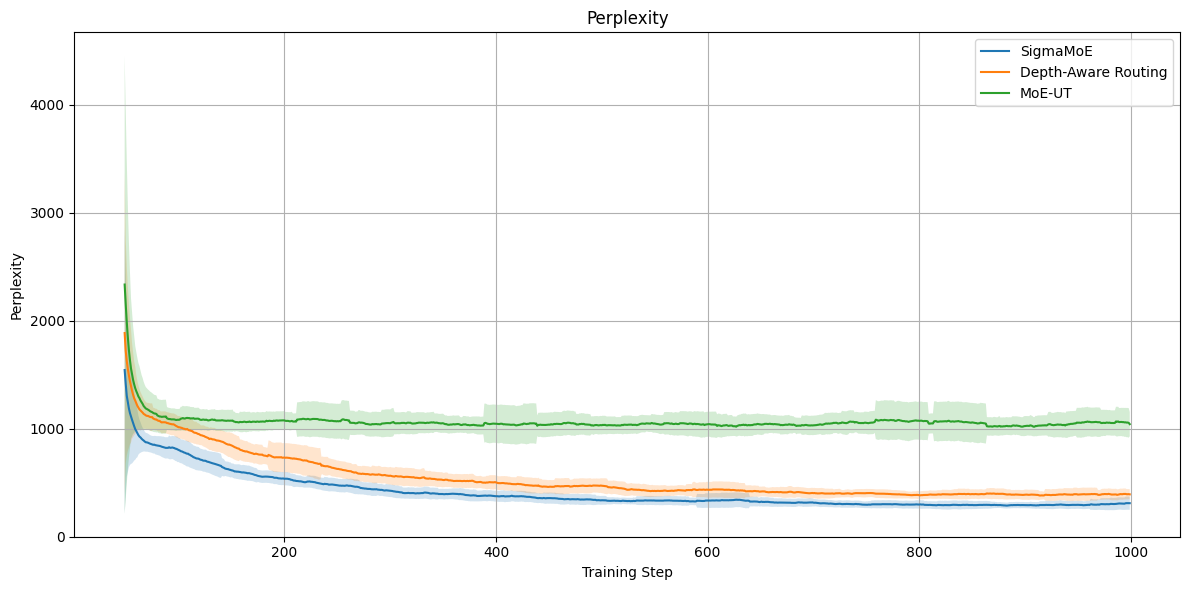

In [ ]:
# Fix parsing using correct delimiter and skip the malformed header row
sigmoe_df_fixed = pd.read_csv('/content/drive/MyDrive/sigmamoe_20m_1000stp_finaltraining_loss_log.csv', skiprows=1, header=None)
depthaware_df_fixed = pd.read_csv('/content/drive/MyDrive/depth_aware_routing_1000stpstraining_loss_log.csv', skiprows=1, header=None)
moeut_fixed = pd.read_csv('/content/drive/MyDrive/moeut_20m_1000stpstraining_loss_log.csv', skiprows=1, header=None)


# Columns: step, loss, perplexity
sigmoe_ppl = sigmoe_df_fixed[2].values
depthaware_ppl = depthaware_df_fixed[2].values
moeut_ppl = moeut_fixed[2].values

# Compute rolling stats
sigmoe_ppl_mean, sigmoe_ppl_std = compute_rolling_mean_std(sigmoe_ppl)
depthaware_ppl_mean, depthaware_ppl_std = compute_rolling_mean_std(depthaware_ppl)
moeut_ppl_mean, moeut_ppl_std = compute_rolling_mean_std(moeut_ppl)
x_range = range(49, len(sigmoe_ppl))  # window - 1 to len

# Plot combined perplexity
plt.figure(figsize=(12, 6))
plt.plot(x_range, sigmoe_ppl_mean, label='SigmaMoE')
plt.fill_between(x_range, sigmoe_ppl_mean - sigmoe_ppl_std, sigmoe_ppl_mean + sigmoe_ppl_std, alpha=0.2)

plt.plot(x_range, depthaware_ppl_mean, label='Depth-Aware Routing')
plt.fill_between(x_range, depthaware_ppl_mean - depthaware_ppl_std, depthaware_ppl_mean + depthaware_ppl_std, alpha=0.2)

plt.plot(x_range, moeut_ppl_mean, label='MoE-UT')
plt.fill_between(x_range, moeut_ppl_mean - moeut_ppl_std, moeut_ppl_mean + moeut_ppl_std, alpha=0.2)


plt.title("Perplexity")
plt.xlabel("Training Step")
plt.ylabel("Perplexity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
